In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor,StackingRegressor,VotingRegressor
from sklearn.linear_model import Ridge,LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#for univariate features selection
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(['object', 'category']):
        X[colname], _ = X[colname].factorize()
    #discrete feature now have integer dtypes
    X=X.fillna(0)
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #discrete_features = [isinstance(t, (int, long)) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(10, 20))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
url = 'https://raw.githubusercontent.com/Sanyam200452/House-Price-Prediction-/main/house_train.csv'
train = pd.read_csv(url)

url2 = 'https://raw.githubusercontent.com/Sanyam200452/House-Price-Prediction-/main/house_test.csv'
test = pd.read_csv(url2)

In [4]:
X=train.copy()
y= X['SalePrice']
X.drop(columns=['SalePrice'],axis = 1, inplace = True)

In [5]:
X.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
1         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
2         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
3         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
4         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      2    2008        WD         Normal  
1       0      5    2007        WD         Normal  
2       0      9    2008        WD         Normal  
3       0      2    2006        WD        Abnorml  
4       0     12    2008        WD         Normal  

[5 rows x 80 columns]

In [6]:
X.drop('Id',axis=1,inplace=True)

##EDA


In [7]:
pd.set_option('display.max_rows', None)
X.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object
CentralAir        object
Electrical        object
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64
GarageFinish      object
GarageCars         int64
GarageArea         int64
GarageQual        object
GarageCond        object
PavedDrive        object
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
PoolQC            object
Fence             object
MiscFeature       object
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
dtype: object

In [8]:
X.isnull().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeature      1406
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
dtype: int64

In [ ]:
X.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    70.049958   10516.828082     6.099315     5.575342   
std      42.300571    24.284752    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    80.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315   
std      30.202904     20.645407   181.066207   456.098091   161.319273   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000   

         BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000   1460.000000   
mean    567.240411  1057.429452  1162.626712   346.992466      5.844521   
std     441.866955   438.705324   386.587738   436.528436     48.623081   
min       0.000000     0.000000   334.000000     0.000000      0.000000   
25%     223.000000   795.750000   882.000000     0.000000      0.000000   
50%     477.500000   991.500000  1087.000000     0.000000      0.000000   
75%     808.000000  1298.250000  1391.250000   728.000000      0.000000   
max    2336.000000  6110.000000  4692.000000  2065.000000    572.000000   

         GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   1515.463699      0.425342      0.057534     1.565068     0.382877   
std     525.480383      0.518911      0.238753     0.550916     0.502885   
min     334.000000      0.000000      0.000000     0.000000     0.000000   
25%    1129.500000      0.000000      0.000000     1.000000     0.000000   
50%    1464.000000      0.000000      0.000000     2.000000     0.000000   
75%    1776.750000      1.000000      0.000000     2.000000     1.000000   
max    5642.000000      3.000000      2.000000     3.000000     2.000000   

       BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt  \
count   1460.000000   1460.000000   1460.000000  1460.000000  1379.000000   
mean       2.866438      1.046575      6.517808     0.613014  1978.506164   
std        0.815778      0.220338      1.625393     0.644666    24.689725   
min        0.000000      0.000000      2.000000     0.000000  1900.000000   
25%        2.000000      1.000000      5.000000     0.000000  1961.000000   
50%        3.000000      1.000000      6.000000     1.000000  1980.000000   
75%        3.000000      1.000000      7.000000     1.000000  2002.000000   
max        8.000000      3.000000     14.000000     3.000000  2010.000000   

        GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch  \
count  1460.000000  1460.000000  1460.000000  1460.000000    1460.000000   
mean      1.767123   472.980137    94.244521    46.660274      21.954110   
std       0.747315   213.804841   125.338794    66.256028      61.119149   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       1.000000   334.500000     0.000000     0.000000       0.000000   
50%       2.000000   480.000000     0.000000    25.000000       0.000000   
75%       2.000000   576.000000   168.000000    68.000000   

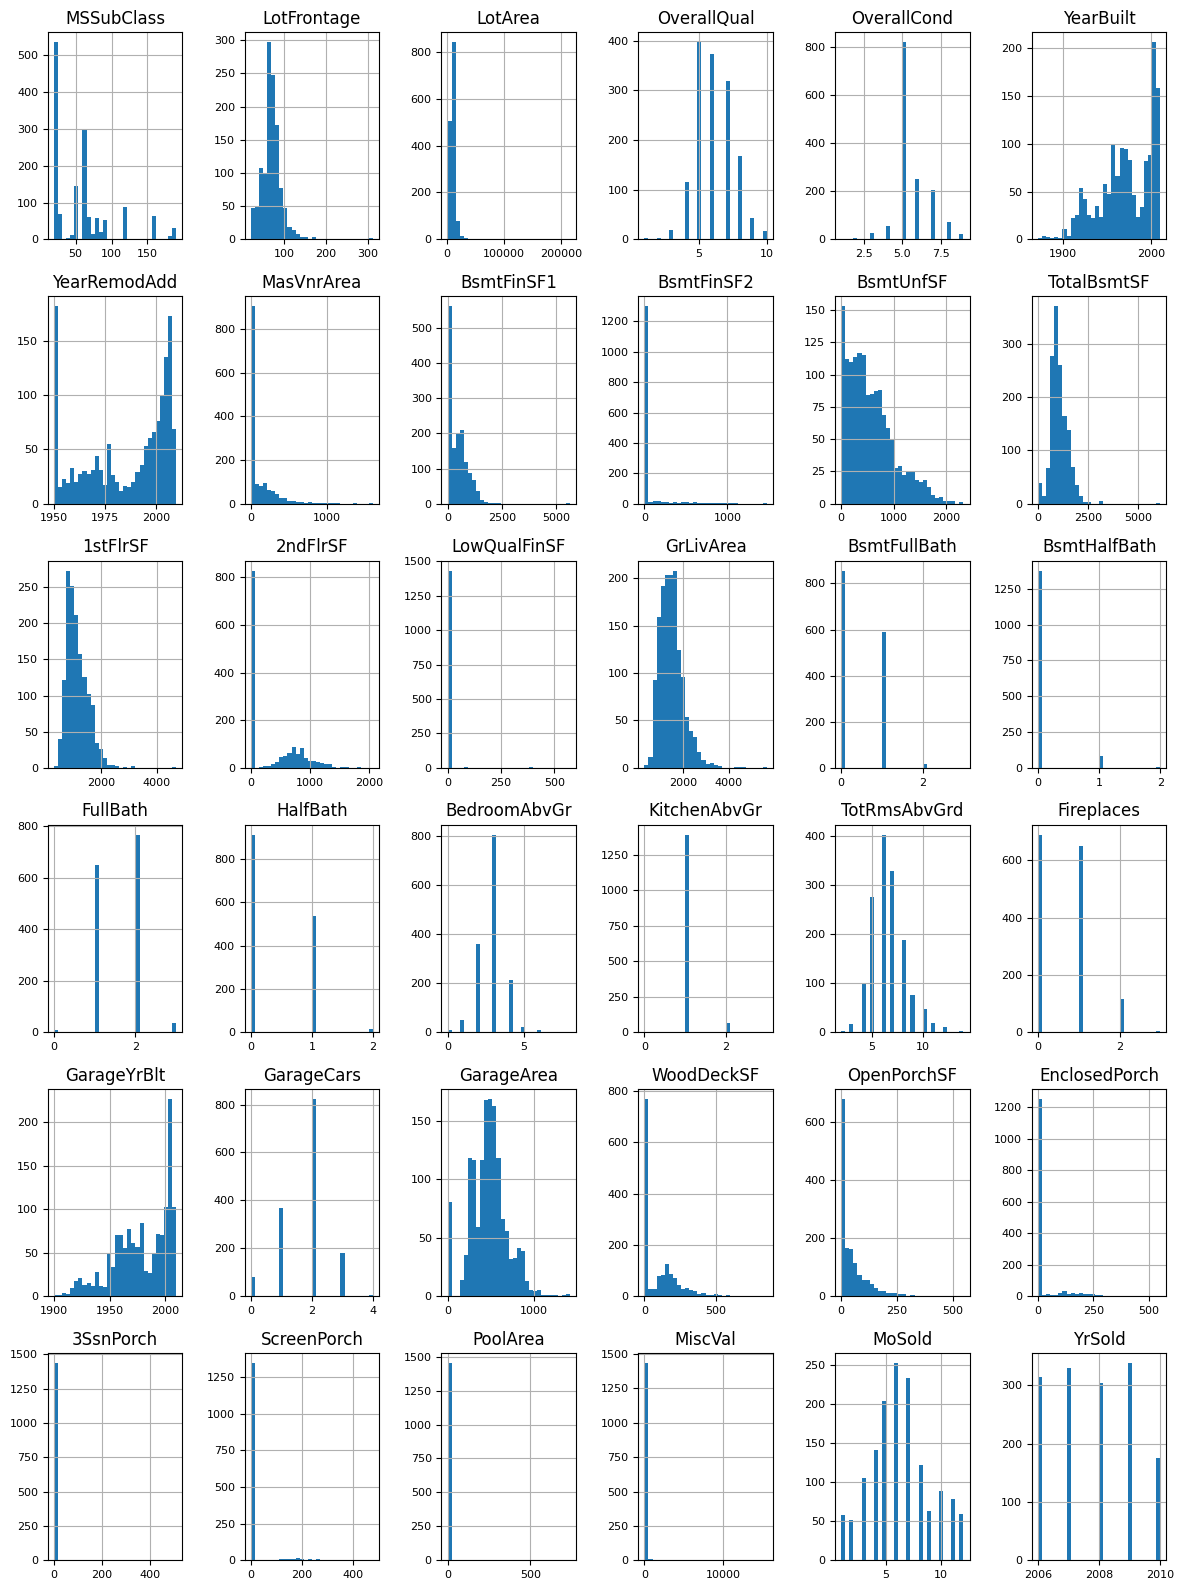

In [9]:
X.select_dtypes(exclude=['object']).hist(figsize=(12,16), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [10]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)


<Figure size 2000x1200 with 0 Axes>

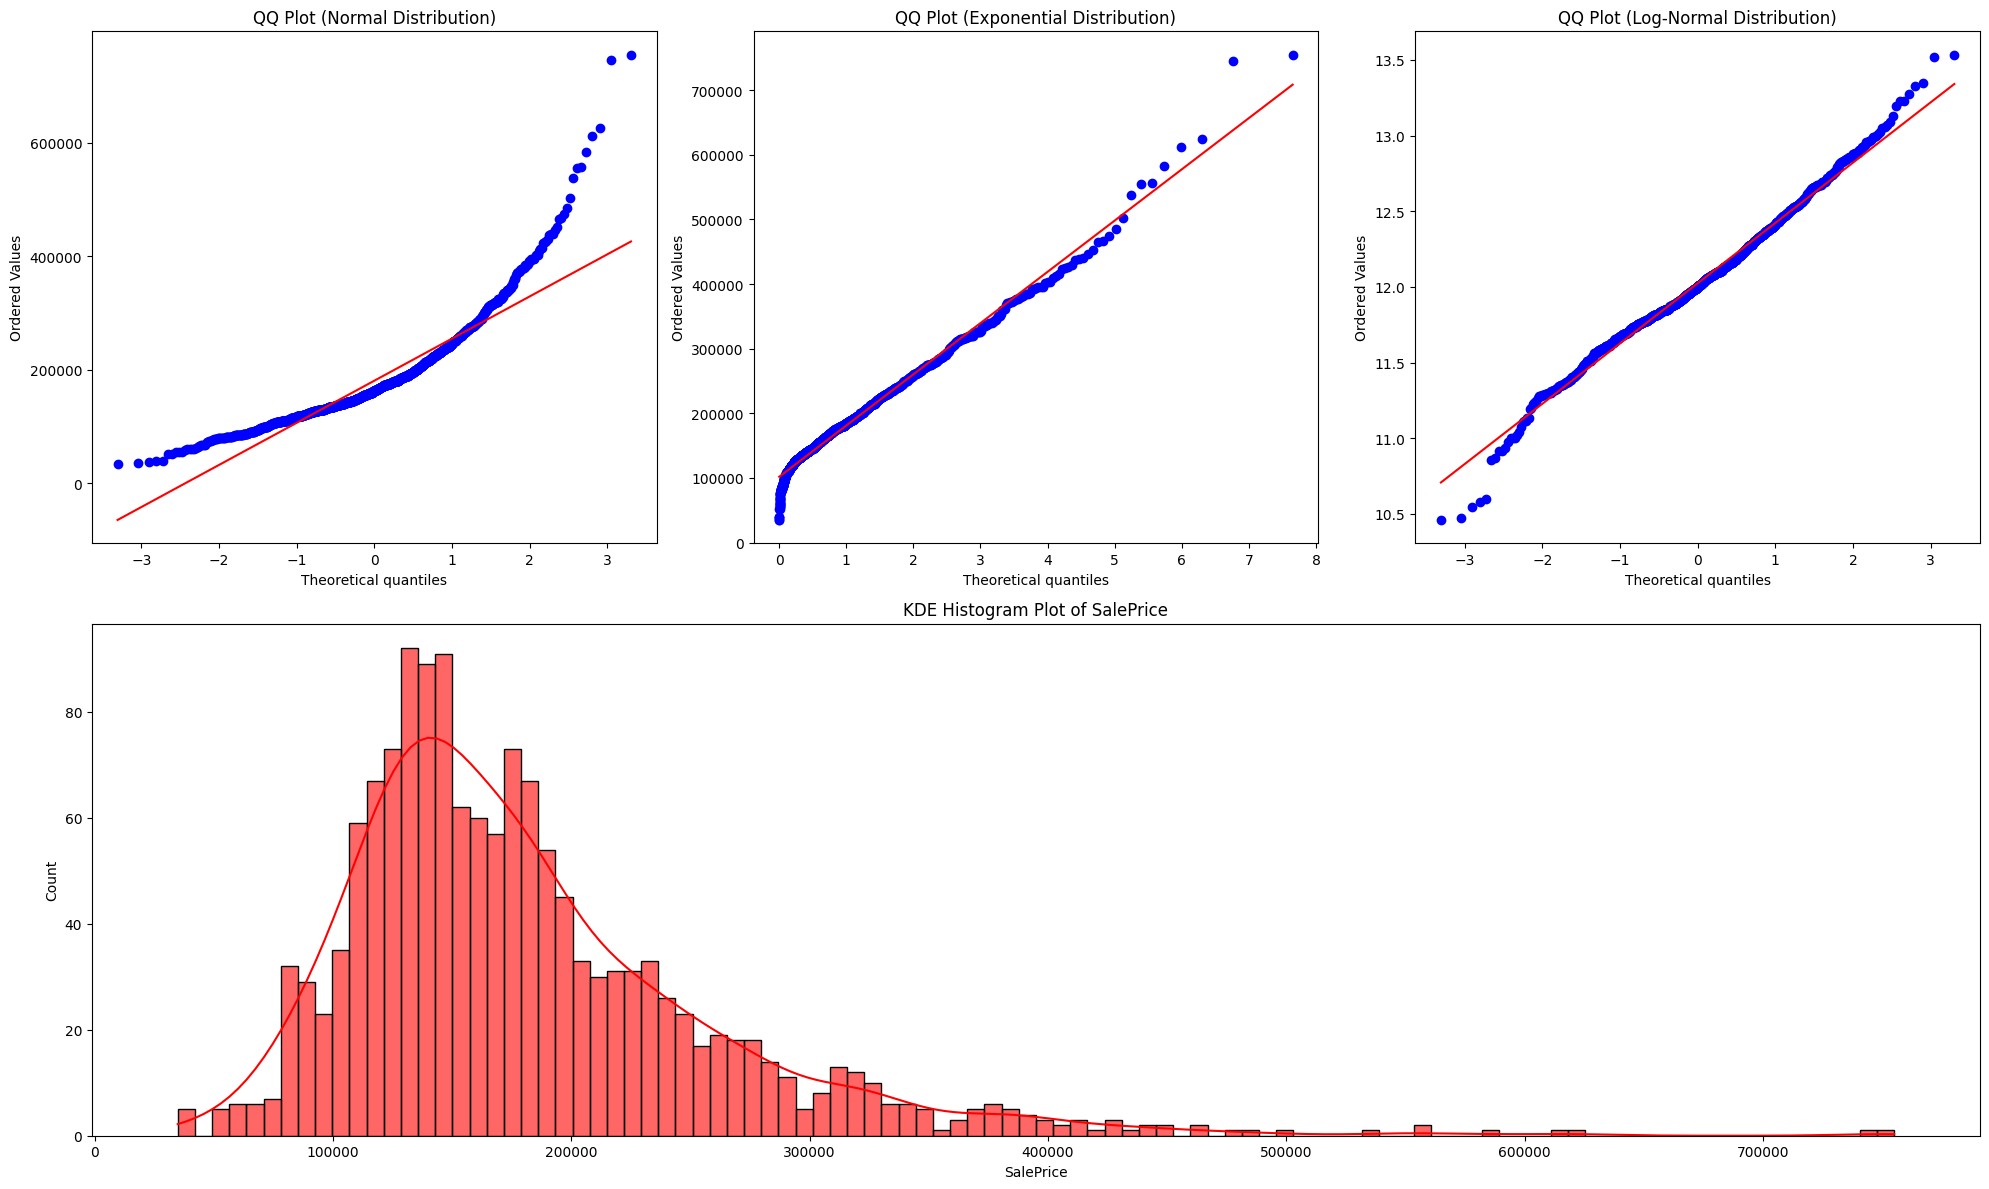

In [12]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 3)

ax0 = fig.add_subplot(gs[1, :])
sns.histplot(y, bins=100, kde=True, alpha=0.6, color='r', ax=ax0)
ax0.set_title('KDE Histogram Plot of SalePrice')

ax1 = fig.add_subplot(gs[0, 0])
stats.probplot(y, dist="norm", plot=ax1)
ax1.set_title('QQ Plot (Normal Distribution)')

ax2 = fig.add_subplot(gs[0, 1])
stats.probplot(y, dist="expon", plot=ax2)
ax2.set_title('QQ Plot (Exponential Distribution)')

ax3 = fig.add_subplot(gs[0, 2])
stats.probplot(np.log(y), dist="norm", plot=ax3)
ax3.set_title('QQ Plot (Log-Normal Distribution)')

plt.tight_layout()
plt.show()

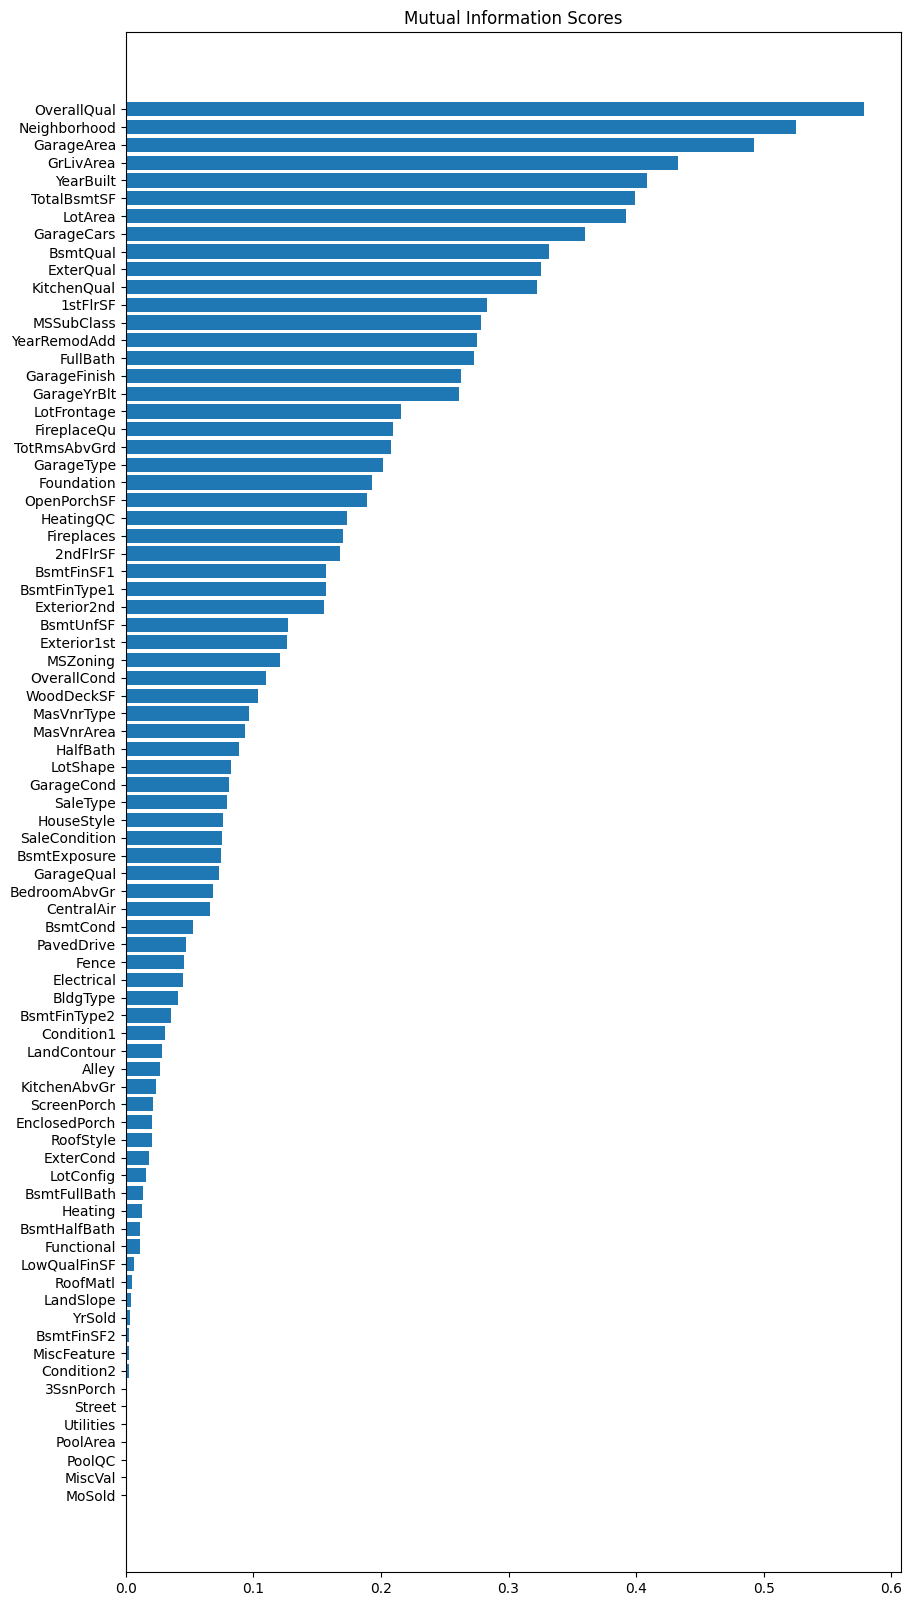

In [13]:
mi_scores=make_mi_scores(X,y)
plot_mi_scores(mi_scores)

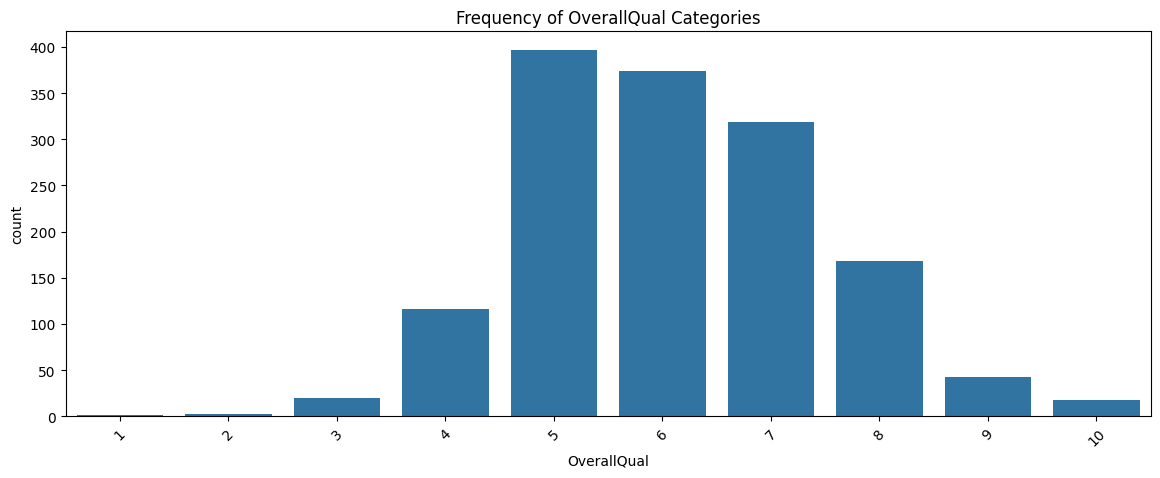

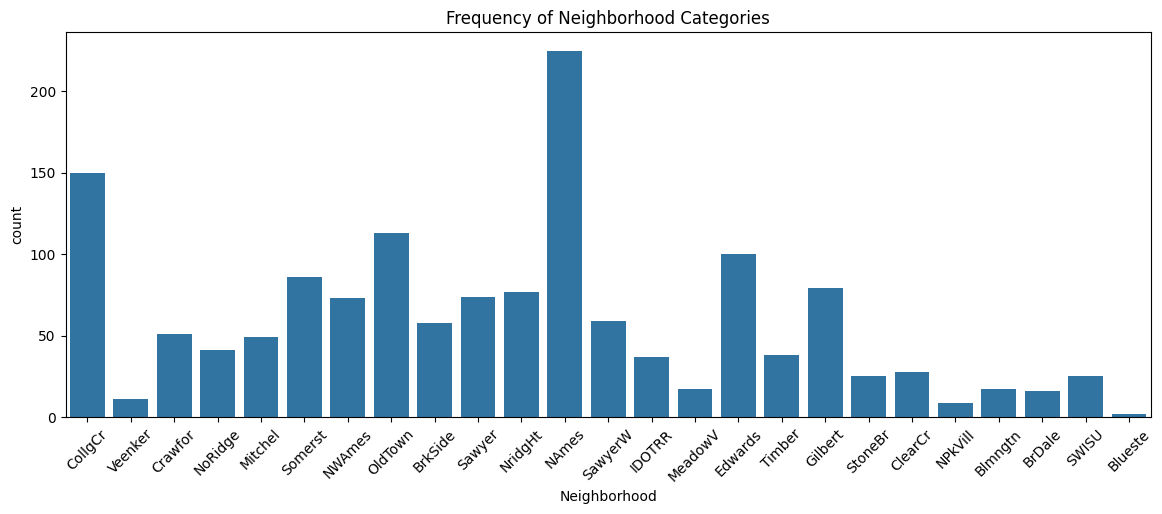

In [14]:
columns_to_plot = ['OverallQual', 'Neighborhood']
for column in columns_to_plot:
    plt.figure(figsize = (14, 5))
    sns.countplot(x=column, data=X)
    plt.title(f'Frequency of {column} Categories')
    plt.xticks(rotation=45)

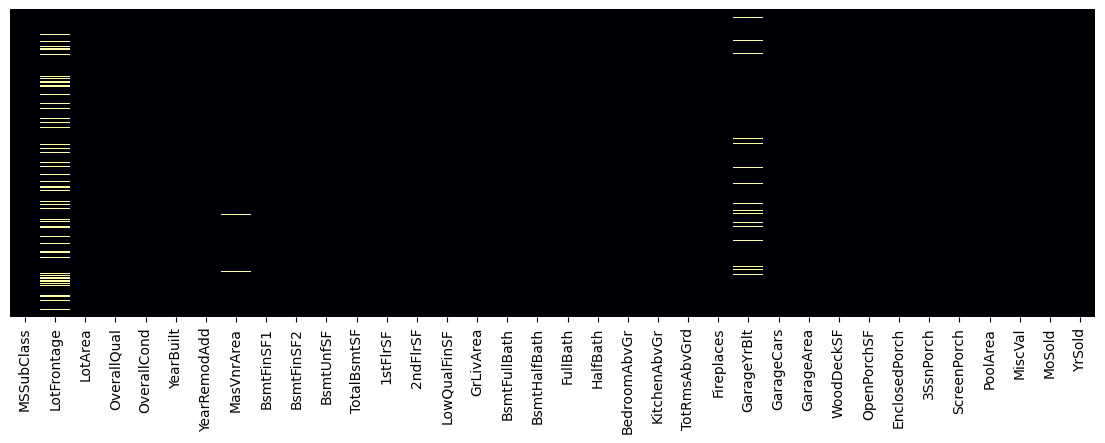

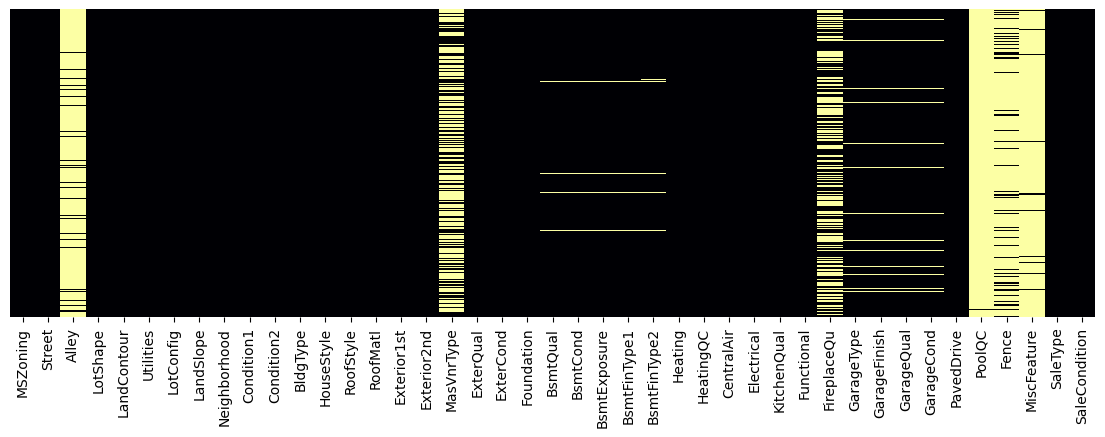

In [15]:
#shows missing values separately from numerical and categorical features

X_num = X.select_dtypes(exclude=['object'])
X_obj = X.drop(columns=X_num)
heatmap_dfs = [X_num,X_obj]
for df in heatmap_dfs:
    plt.figure(figsize=(14, 4))
    sns.heatmap(df.isnull(), cbar=False, cmap='inferno', yticklabels=False)
    plt.show()

In [16]:
features_to_drop = ['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature']

In [17]:
X["Alley"].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

In [18]:
X["BsmtQual"].value_counts()

BsmtQual
TA    649
Gd    618
Ex    121
Fa     35
Name: count, dtype: int64

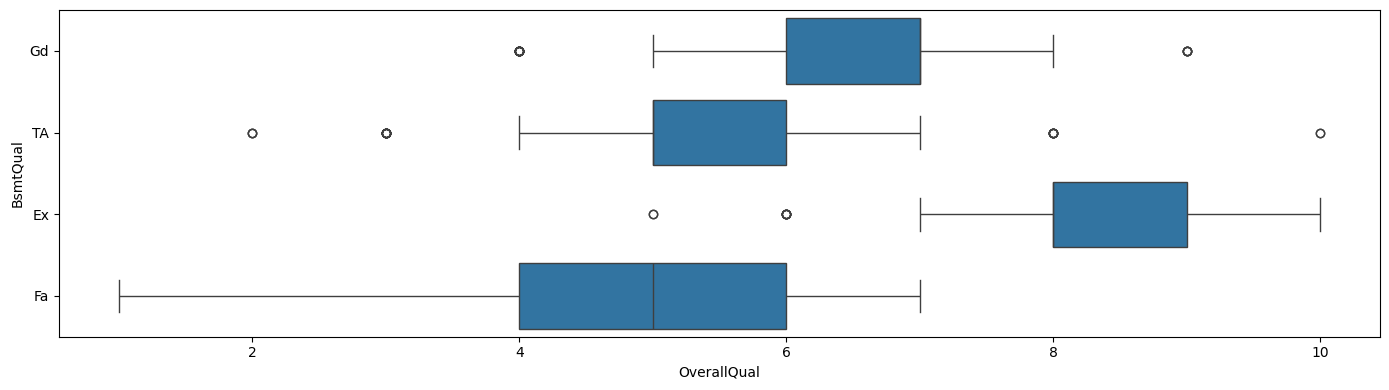

In [19]:
plt.figure(figsize=(14,4))
sns.boxplot(x="OverallQual",y="BsmtQual",data=X)
plt.tight_layout()

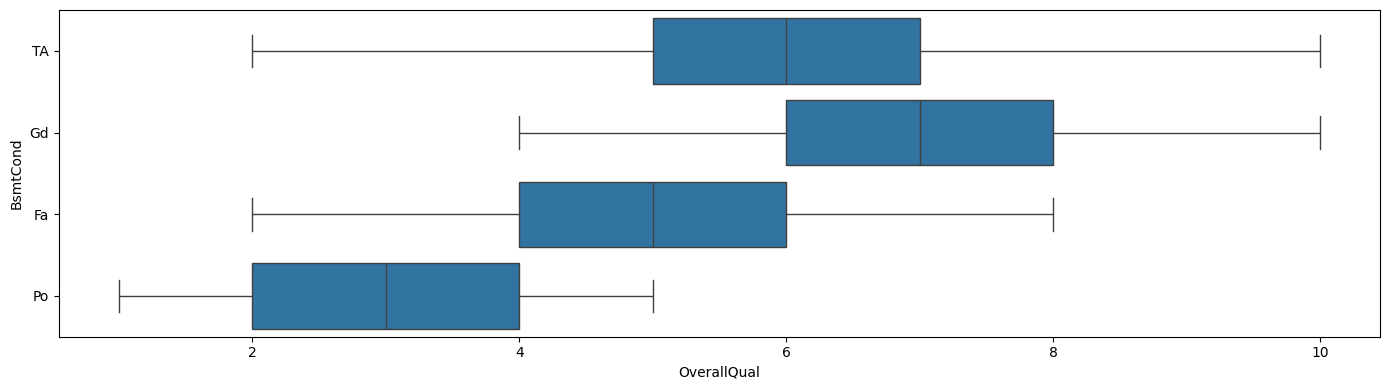

In [ ]:
plt.figure(figsize=(14,4))
sns.boxplot(x="OverallQual",y="BsmtCond",data=X)
plt.tight_layout()
# FIll fill null values according to this now

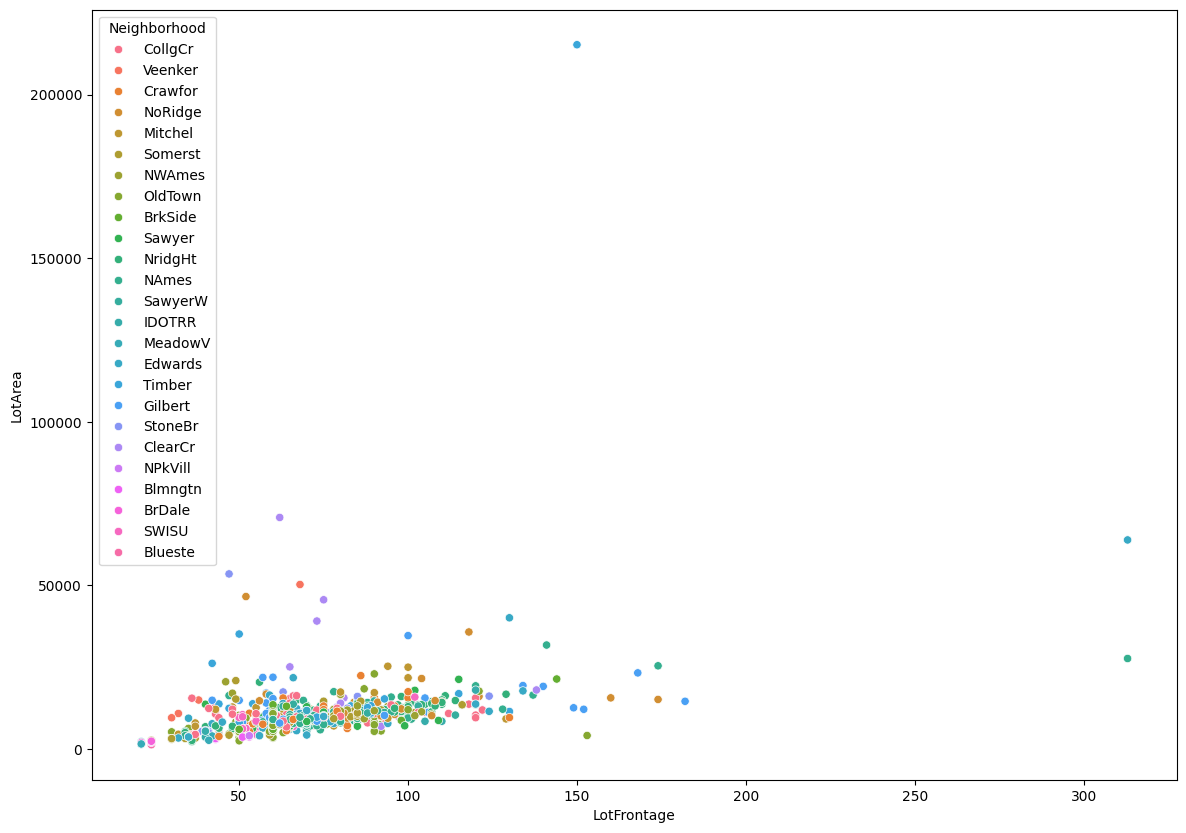

In [20]:
plt.figure(figsize=(14,10))
sns.scatterplot(x="LotFrontage", y="LotArea", hue="Neighborhood", data=X)
plt.show()

In [21]:
frequency_table = pd.crosstab(X['Neighborhood'], X['MasVnrType'])
chi2, p, _, _ = chi2_contingency(frequency_table)
print(frequency_table)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

MasVnrType    BrkCmn  BrkFace  Stone
Neighborhood                        
Blmngtn            0       16      0
BrDale             0       15      0
BrkSide            1        2      0
ClearCr            2        5      1
CollgCr            0       61     14
Crawfor            0       11      3
Edwards            0       15     10
Gilbert            0       18      2
IDOTRR             0        1      0
MeadowV            0        1      0
Mitchel            0       13      2
NAmes              7       86      9
NWAmes             0       50      3
NoRidge            0       33      0
NridgHt            0       34     41
OldTown            1        3      1
SWISU              0        1      0
Sawyer             4       17      1
SawyerW            0       20      2
Somerst            0       16     27
StoneBr            0        6      6
Timber             0       20      6
Veenker            0        1      0
Chi-square value: 218.60141108726592
P-value: 5.315779877965319e-25


In [22]:
#p value less than 0.05, hence null hypothesis is denied

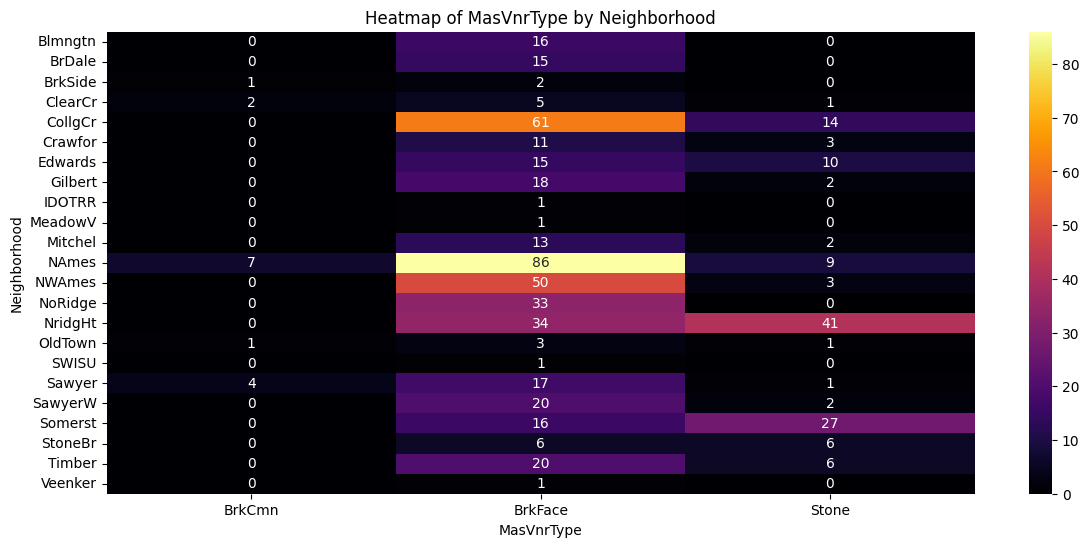

In [23]:
plt.figure(figsize=(14, 6))
sns.heatmap(frequency_table, annot=True, cmap='inferno', fmt='g', cbar=True)
plt.title('Heatmap of MasVnrType by Neighborhood')
plt.show()
#For each neighborhood, there are different masonry veneer type

In [24]:
frequency_table = pd.crosstab(X['LotFrontage'], X['LotArea'])
chi2, p, _, _ = chi2_contingency(frequency_table)
#print(frequency_table)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

Chi-square value: 124263.62660903041
P-value: 0.0


In [25]:
frequency_table = pd.crosstab(X['LotFrontage'], X['Neighborhood'])
chi2, p, _, _ = chi2_contingency(frequency_table)
#print(frequency_table)
print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

Chi-square value: 6107.5918080055535
P-value: 2.3715512073658795e-279


In [26]:
frequency_table2 = pd.crosstab(X['LotFrontage'], X['LotArea'])
chi22, p2, _, _ = chi2_contingency(frequency_table2)
#print(frequency_table2)
print(f"Chi-square value: {chi22}")
print(f"P-value: {p2}")

Chi-square value: 124263.62660903041
P-value: 0.0


In [27]:
correlation_coefficient=X["LotArea"].corr(X["LotFrontage"])
correlation_coefficient

0.42609501877180833

In [28]:
def get_mode(x):
    mode_value=x.mode()
    return mode_value.iloc[0] if not mode_value.empty else None

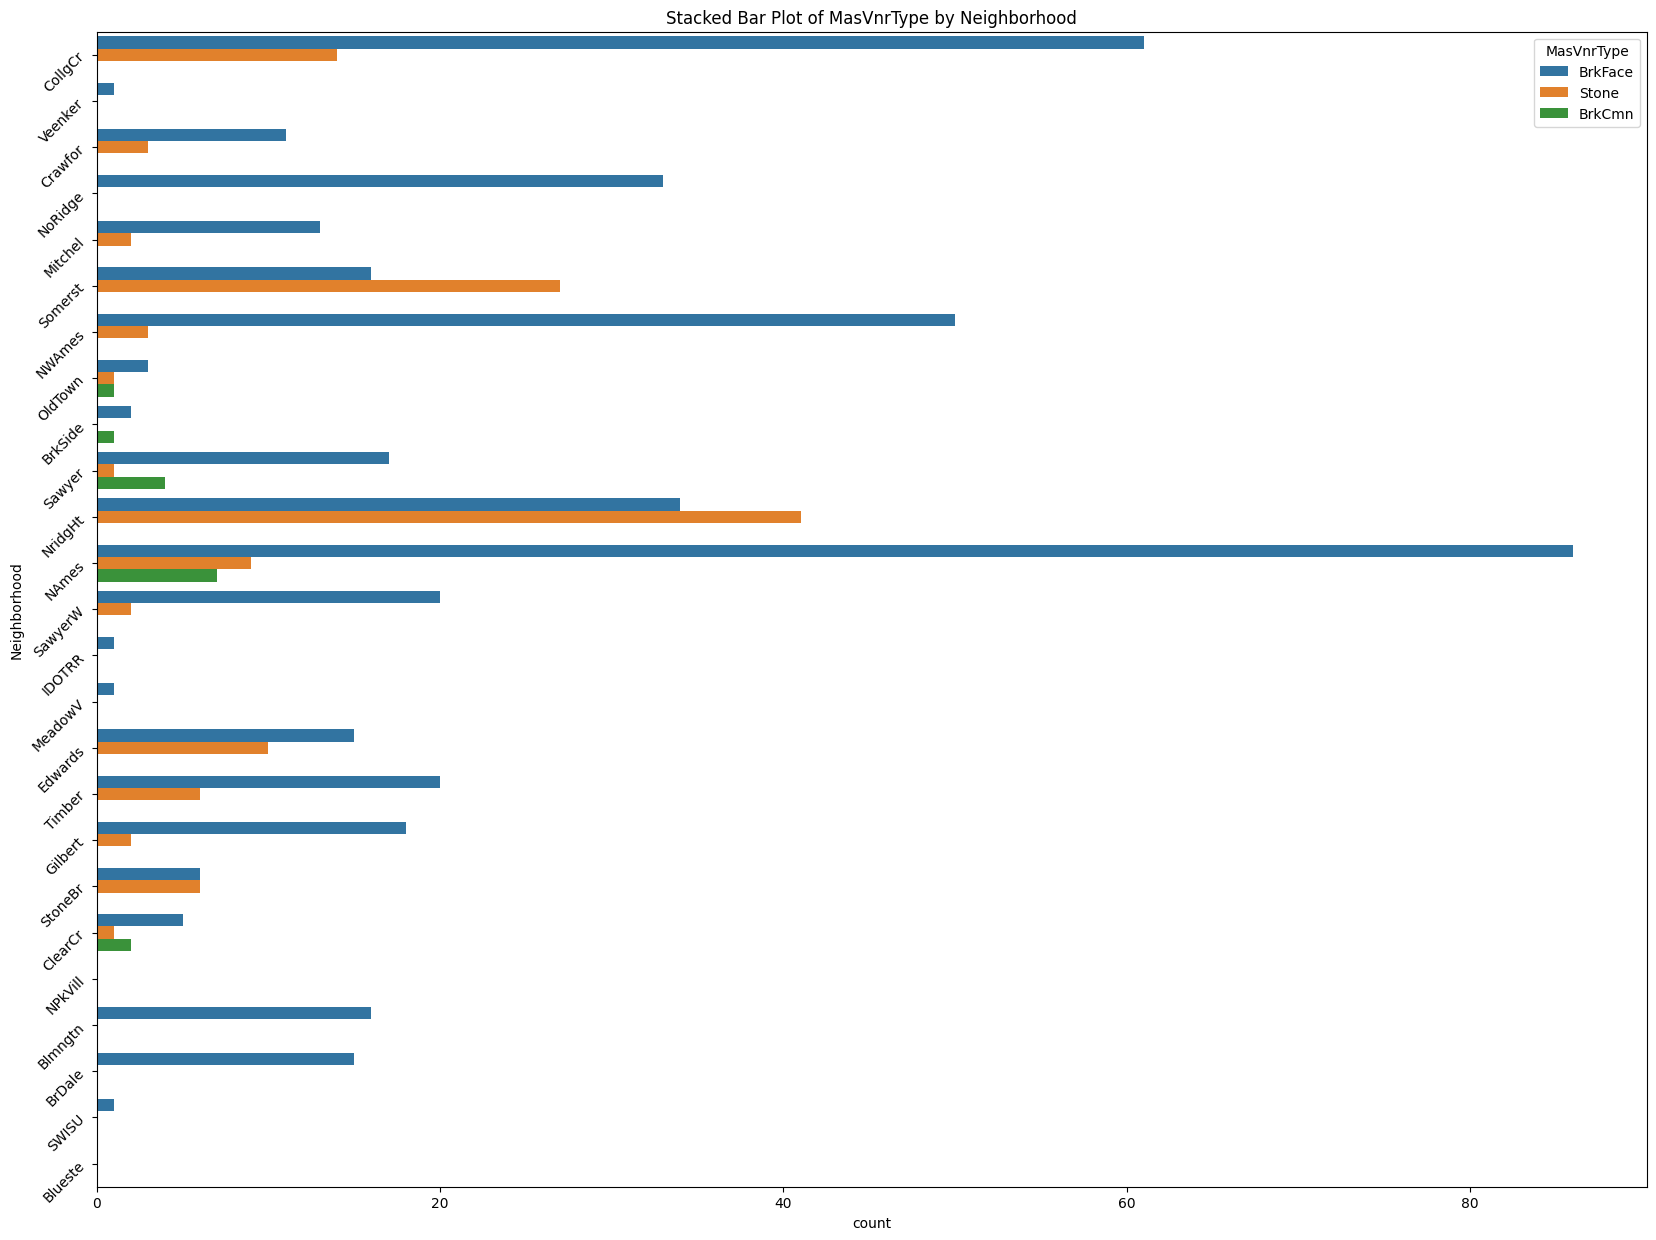

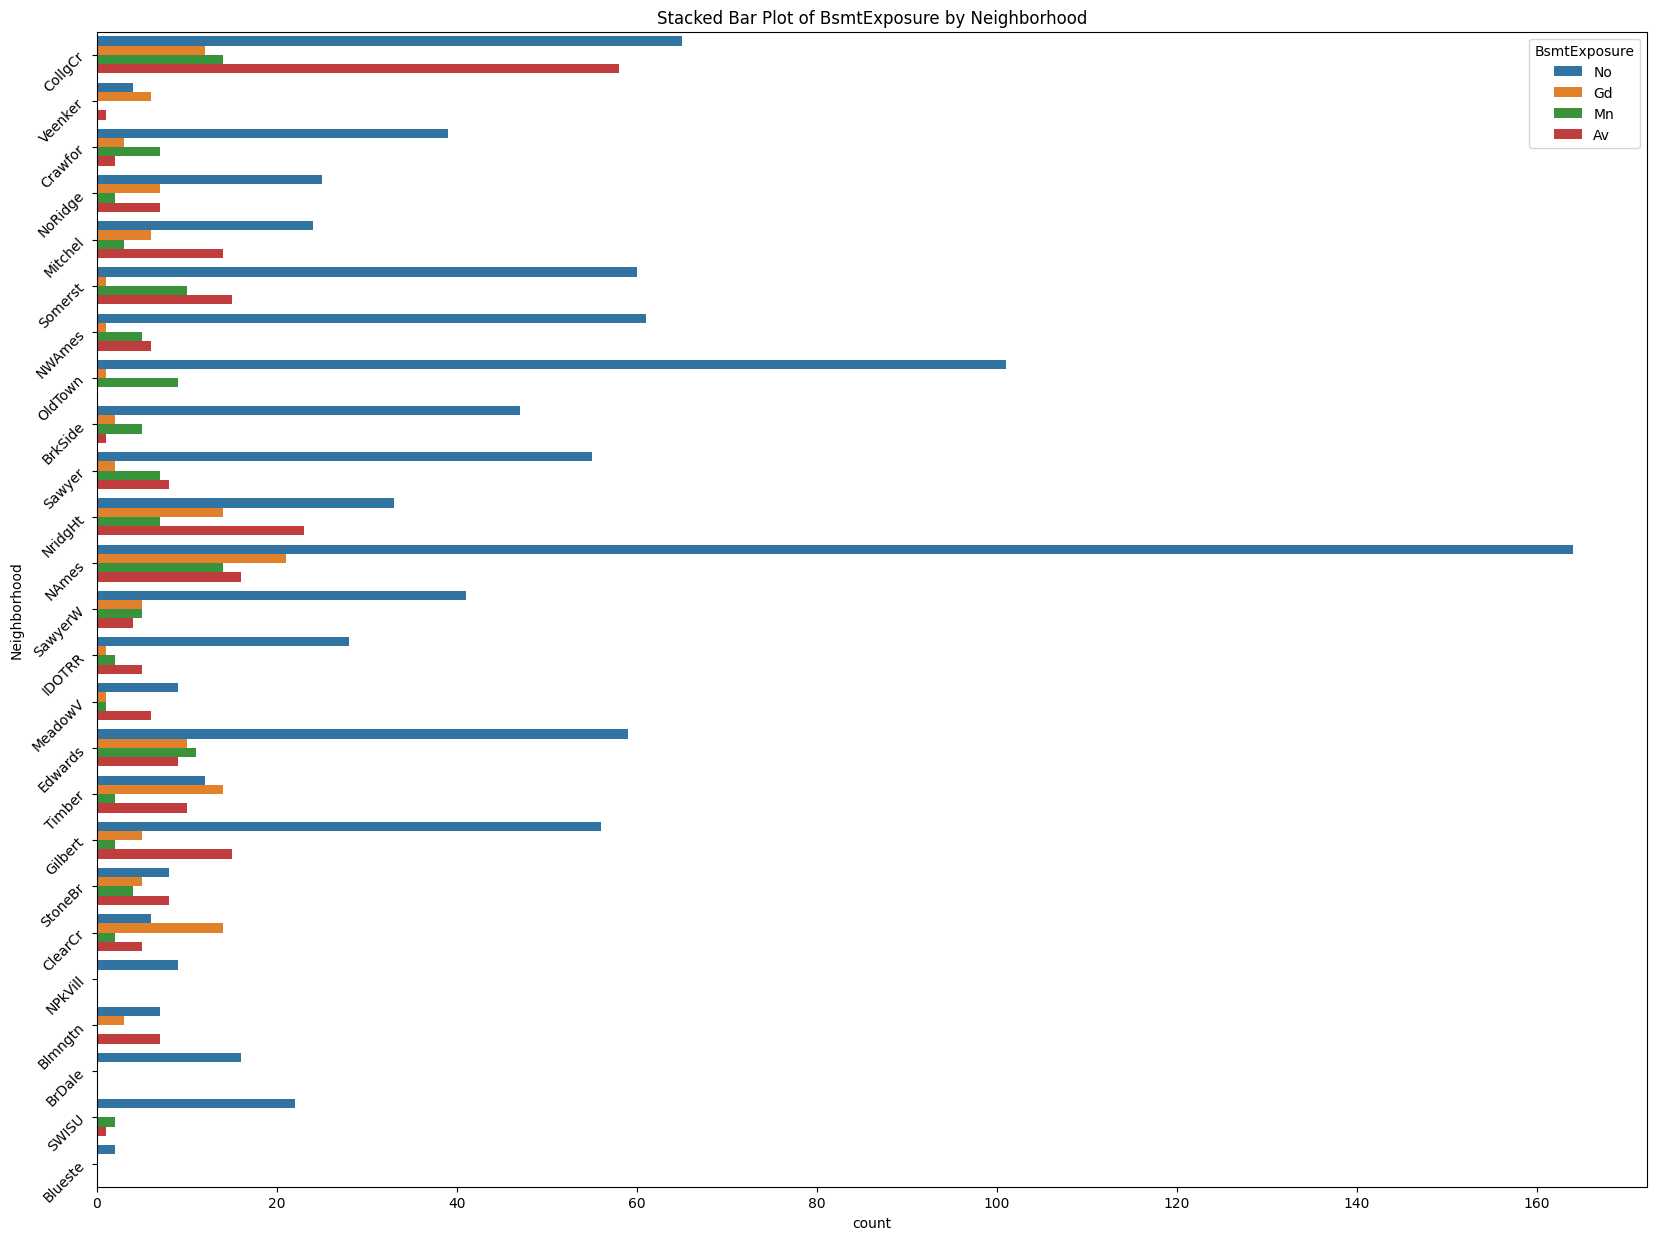

In [29]:
def barplot(y,hue,X):
    plt.figure(figsize=(20, 15))
    sns.countplot(y=y, hue=hue, data=X,)
    plt.title(f'Stacked Bar Plot of {hue} by Neighborhood')
    plt.yticks(rotation=45)
    plt.show()
hue = ['MasVnrType','BsmtExposure']
for hue in hue:
    barplot('Neighborhood',hue,X)

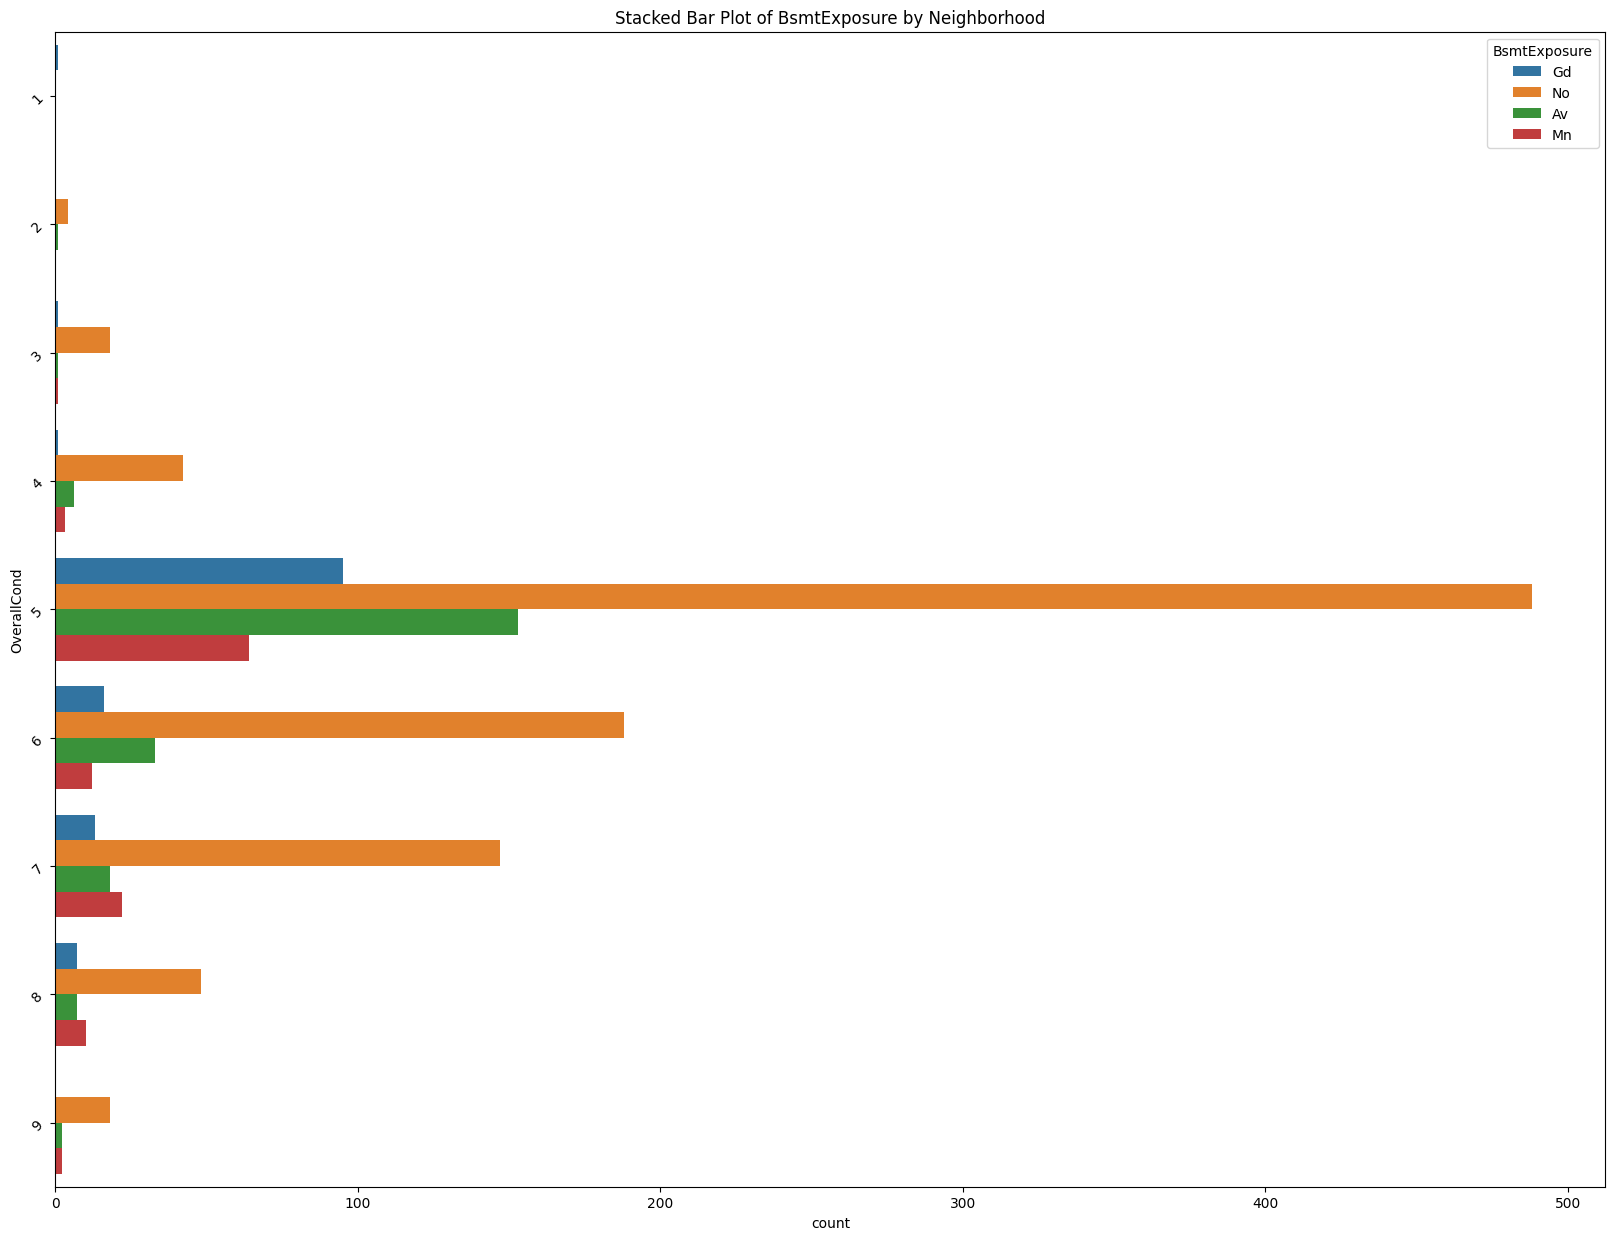

In [30]:
barplot('OverallCond','BsmtExposure',X)

<div style="text-align: center;">
  <h2 style="font-family: 'Arial', sans-serif; padding-bottom: 3px; font-size: 24px; color: #FF073A; display: inline-block; background-color: #FFD999;">DATA PREPROCESSING</h2>
</div>


In [31]:
X.drop(features_to_drop,axis=1,inplace=True)

In [32]:
fX_num = X.select_dtypes(include=["int64","float64"])
X_obj = X.drop(columns=X_num)
fX_num

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
5             50         85.0    14115            5            5       1993   
6             20         75.0    10084            8            5       2004   
7             60          NaN    10382            7            6       1973   
8             50         51.0     6120            7            5       1931   
9            190         50.0     7420            5            6       1939   
10            20         70.0    11200            5            5       1965   
11            60         85.0    11924            9            5       2005   
12            20          NaN    12968            5            6       1962   
13            20         91.0    10652            7            5       2006   
14            20          NaN    10920            6            5       1960   
15            45         51.0     6120            7            8       1929   
16            20          NaN    11241            6            7       1970   
17            90         72.0    10791            4            5       1967   
18            20         66.0    13695            5            5       2004   
19            20         70.0     7560            5            6       1958   
20            60        101.0    14215            8            5       2005   
21            45         57.0     7449            7            7       1930   
22            20         75.0     9742            8            5       2002   
23           120         44.0     4224            5            7       1976   
24            20          NaN     8246            5            8       1968   
25            20        110.0    14230            8            5       2007   
26            20         60.0     7200            5            7       1951   
27            20         98.0    11478            8            5       2007   
28            20         47.0    16321            5            6       1957   
29            30         60.0     6324            4            6       1927   
30            70         50.0     8500            4            4       1920   
31            20          NaN     8544            5            6       1966   
32            20         85.0    11049            8            5       2007   
33            20         70.0    10552            5            5       1959   
34           120         60.0     7313            9            5       2005   
35            60        108.0    13418            8            5       2004   
36            20        112.0    10859            5            5       1994   
37            20         74.0     8532            5            6       1954   
38            20         68.0     7922            5            7       1953   
39            90         65.0     6040            4            5       1955   
40            20         84.0     8658            6            5       1965   
41            20        115.0    16905            5            6       1959   
42            85          NaN     9180            5            7       1983   
43            20          NaN     9200            5            6       1975   
44            20         70.0     7945            5            6       1959   
45           120         61.0     7658            9            5       2005   
46            50         48.0    12822            7            5       2003   
47            20         84.0    11096            8            5       2006   
48           190         33.0     4456            4            5       1920   
49            20         66.0     7742            5     

In [33]:
#to show all columns when printed
pd.reset_option("display.max_rows")
pd.set_option("display.max_columns",None)

In [34]:
#filling empty values of lot frontage with average values of lot frontage in that neighbourhood
Lot_avg=X.groupby("Neighborhood")["LotFrontage"].mean()
X_num["LotFrontage"]=X["LotFrontage"].fillna(X["Neighborhood"].map(Lot_avg))
Lot_avg

Neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.562500
BrkSide    57.509804
ClearCr    83.461538
CollgCr    71.682540
Crawfor    71.804878
Edwards    68.217391
Gilbert    79.877551
IDOTRR     62.500000
MeadowV    27.800000
Mitchel    70.083333
NAmes      76.462366
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.881579
OldTown    62.788991
SWISU      58.913043
Sawyer     74.437500
SawyerW    71.500000
Somerst    64.666667
StoneBr    62.700000
Timber     80.133333
Veenker    59.714286
Name: LotFrontage, dtype: float64

In [ ]:
X.groupby("Neighborhood")["LotFrontage"].mean(), (X["Neighborhood"].map(Lot_avg))

(Neighborhood
 Blmngtn    47.142857
 Blueste    24.000000
 BrDale     21.562500
 BrkSide    57.509804
 ClearCr    83.461538
 CollgCr    71.682540
 Crawfor    71.804878
 Edwards    68.217391
 Gilbert    79.877551
 IDOTRR     62.500000
 MeadowV    27.800000
 Mitchel    70.083333
 NAmes      76.462366
 NPkVill    32.285714
 NWAmes     81.288889
 NoRidge    91.878788
 NridgHt    81.881579
 OldTown    62.788991
 SWISU      58.913043
 Sawyer     74.437500
 SawyerW    71.500000
 Somerst    64.666667
 StoneBr    62.700000
 Timber     80.133333
 Veenker    59.714286
 Name: LotFrontage, dtype: float64,
 0       71.682540
 1       59.714286
 2       71.682540
 3       71.804878
 4       91.878788
           ...    
 1455    79.877551
 1456    81.288889
 1457    71.804878
 1458    76.462366
 1459    68.217391
 Name: Neighborhood, Length: 1460, dtype: float64)

In [35]:
X["GarageYrBlt"] = X["GarageYrBlt"].fillna(0) # means no garage, no info available
X_num["GarageYrBlt"] = X["GarageYrBlt"]

In [36]:
MasVnrArea_avg=X.groupby("Neighborhood")["MasVnrArea"].mean()
X["MasVnrArea"]=X["MasVnrArea"].fillna(X["Neighborhood"].map(MasVnrArea_avg))
X_num["MasVnrArea"] = X["MasVnrArea"]

In [37]:
X_num = X_num.fillna(X_num.mean())

In [38]:
X.loc[X["OverallQual"]>=8,"BsmtCond"]=X.loc[X["OverallQual"]>=8,"BsmtQual"].fillna("Ex")
X.loc[X["OverallQual"]>=6,"BsmtCond"]=X.loc[X["OverallQual"]>=6,"BsmtQual"].fillna("Gd")
X.loc[X["OverallQual"]>=5,"BsmtCond"]=X.loc[X["OverallQual"]>=5,"BsmtQual"].fillna("TA")
X.loc[X["OverallQual"]>=4,"BsmtCond"]=X.loc[X["OverallQual"]>=4,"BsmtQual"].fillna("Fa")
X.loc[X["OverallQual"]<=4,"BsmtCond"]=X.loc[X["OverallQual"]<=4,"BsmtQual"].fillna("Po")
X_obj["BsmtCond"] = X['BsmtCond']

In [39]:
X.loc[X["OverallQual"]>=8,"BsmtQual"]=X.loc[X["OverallQual"]>=8,"BsmtQual"].fillna("Ex")
X.loc[(X["OverallQual"] >= 6), "BsmtQual"] = X.loc[(X["OverallQual"] >= 6), "BsmtQual"].fillna("Gd")
X.loc[(X["OverallQual"] >= 4) , "BsmtQual"] = X.loc[(X["OverallQual"] >= 4) , "BsmtQual"].fillna("Fa")
X.loc[X["OverallQual"]<4,"BsmtQual"]=X.loc[X["OverallQual"]<4,"BsmtQual"].fillna("Fa")
X_obj["BsmtQual"] =  X["BsmtQual"]

In [40]:
X["BsmtExposure"]=X["BsmtExposure"].fillna("No")
X_obj['BsmtExposure'] = X['BsmtExposure']

In [41]:
BsmtFintype1_mode=X.groupby("OverallCond")["BsmtFinType1"].transform(lambda x: x.mode().iloc[0])
X["BsmtFinType1"]=X["BsmtFinType1"].fillna(BsmtFintype1_mode)
X_obj["BsmtFinType1"] = X["BsmtFinType1"]
BsmtFintype2_mode=X.groupby("OverallCond")["BsmtFinType2"].transform(lambda x:x.mode().iloc[0])
X["BsmtFinType2"]=X["BsmtFinType2"].fillna(BsmtFintype2_mode)
X_obj["BsmtFinType2"] = X["BsmtFinType2"]

In [42]:
X["Electrical"]=X["Electrical"].fillna("SBrkr")#only one value is missing, replacing that with "Standard Circuit Breakers & Romex"
X_obj["Electrical"] = X["Electrical"]

In [43]:
X["GarageType"].value_counts(), X["GarageFinish"].value_counts()

(GarageType
 Attchd     870
 Detchd     387
 BuiltIn     88
 Basment     19
 CarPort      9
 2Types       6
 Name: count, dtype: int64,
 GarageFinish
 Unf    605
 RFn    422
 Fin    352
 Name: count, dtype: int64)

In [44]:
X["GarageType"]= X["GarageType"].fillna("NG")# No garage
X_obj["GarageType"] = X["GarageType"]
X["GarageFinish"]= X["GarageFinish"].fillna("NG")
X_obj["GarageFinish"] = X["GarageFinish"]
X["GarageQual"]= X["GarageQual"].fillna("NG")
X_obj["GarageQual"] = X["GarageQual"]
X["GarageCond"]= X["GarageCond"].fillna("NG")
X_obj["GarageCond"] = X["GarageCond"]

In [45]:
unique_counts = X_num.apply(lambda x: x.nunique(), axis = 0)
print("Number of unique values in each column:")
print(unique_counts)

Number of unique values in each column:
MSSubClass         15
LotFrontage       133
LotArea          1073
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
MasVnrArea        333
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
BsmtFullBath        4
BsmtHalfBath        3
FullBath            4
HalfBath            3
BedroomAbvGr        8
KitchenAbvGr        4
TotRmsAbvGrd       12
Fireplaces          4
GarageYrBlt        98
GarageCars          5
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
PoolArea            8
MiscVal            21
MoSold             12
YrSold              5
dtype: int64


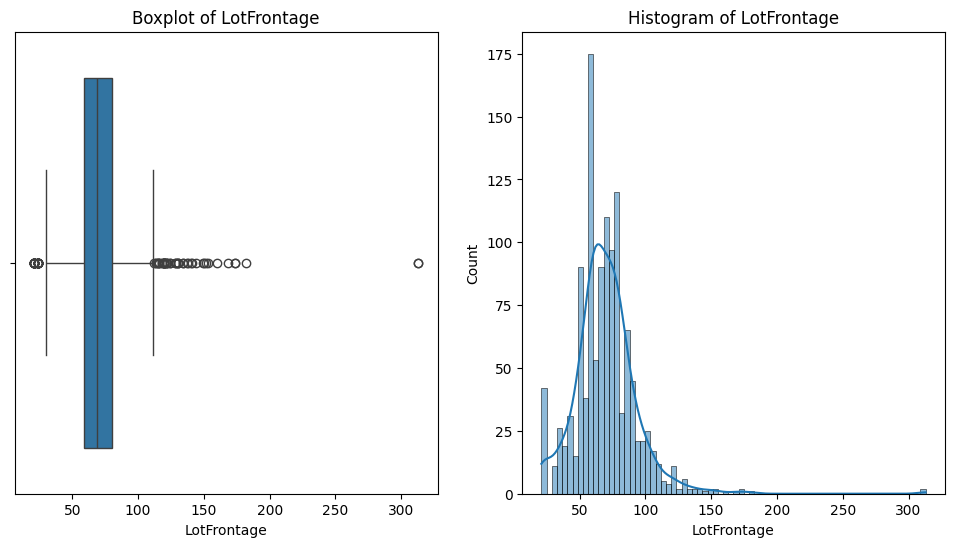

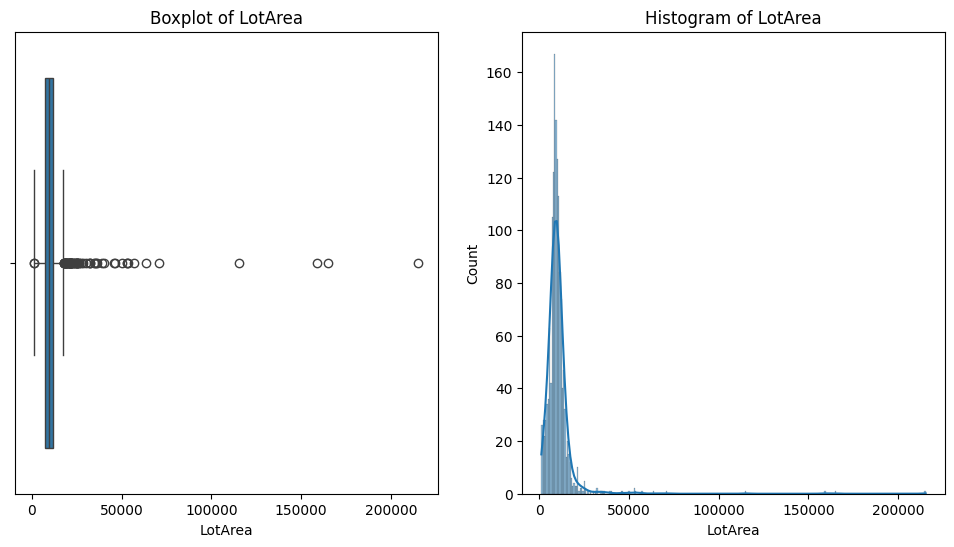

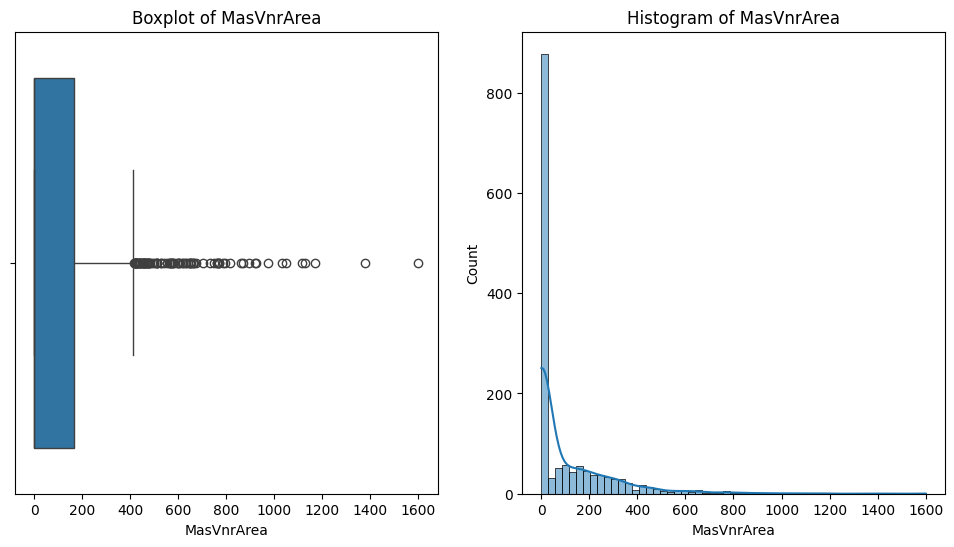

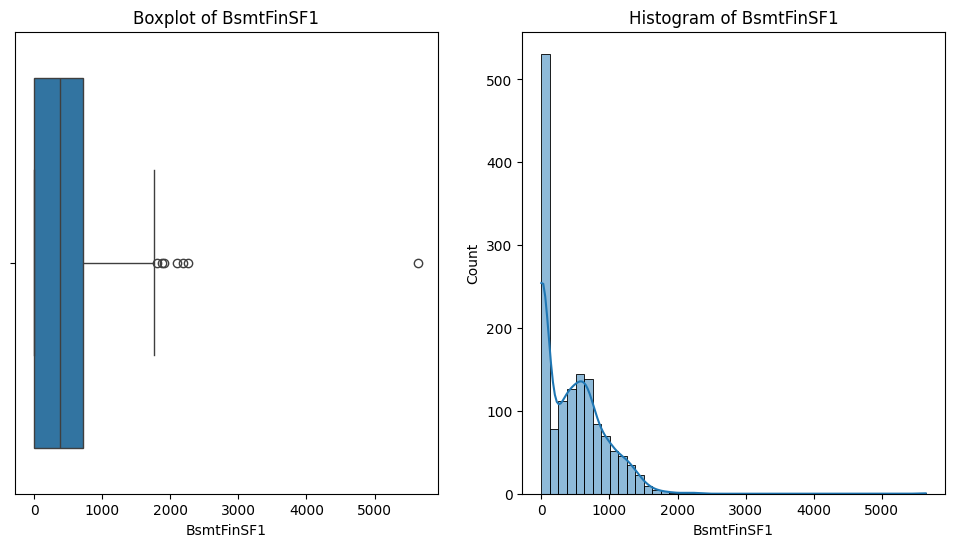

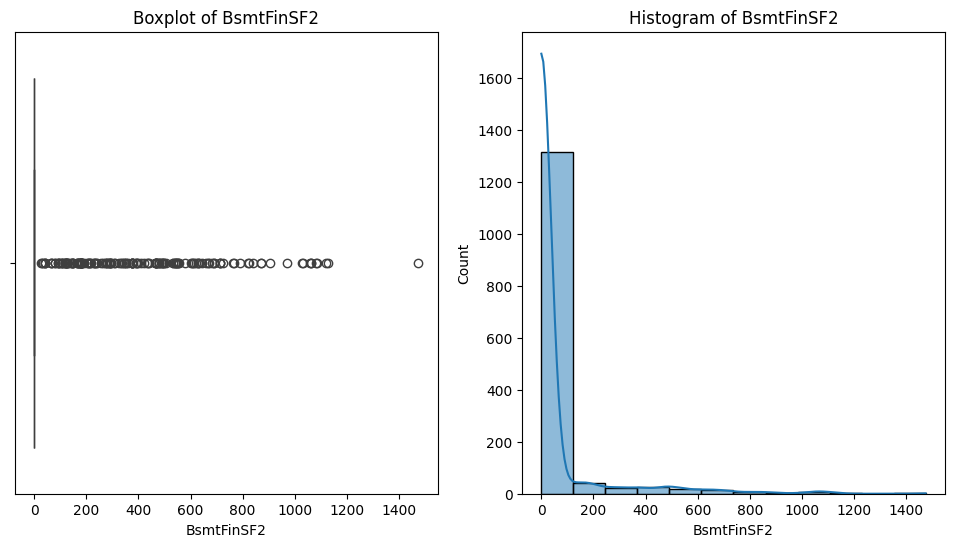

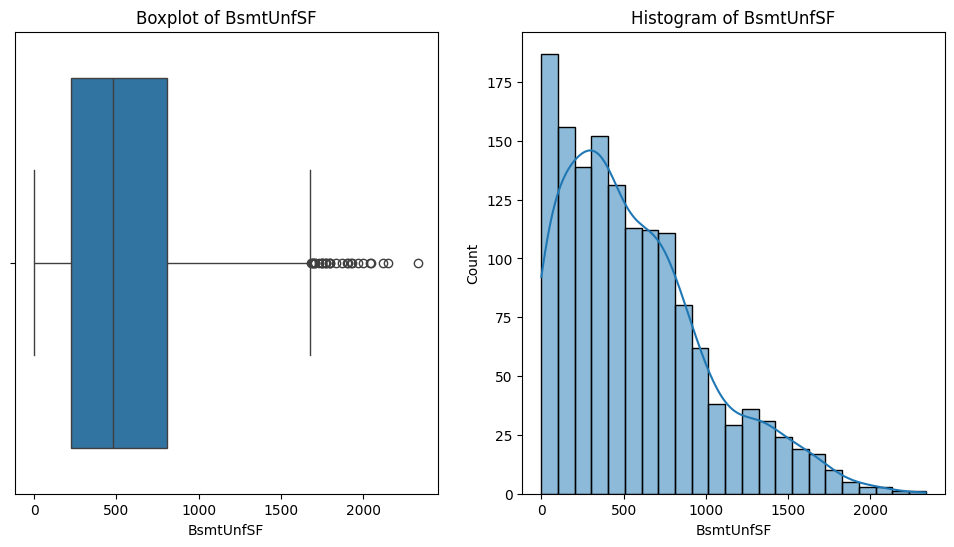

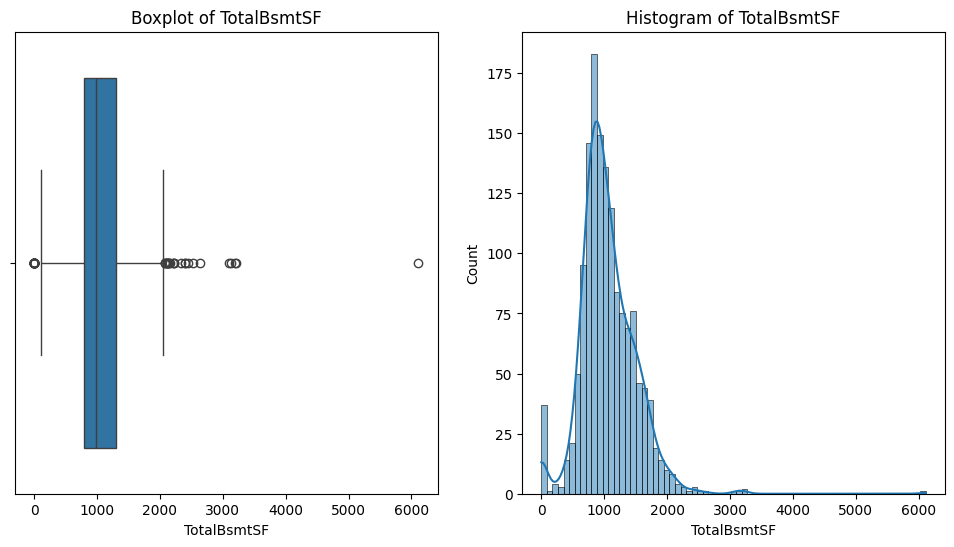

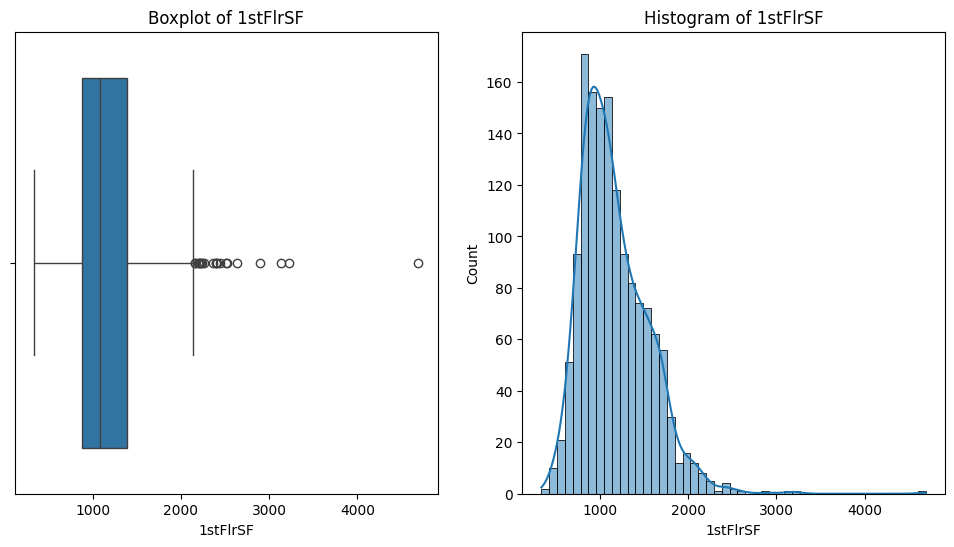

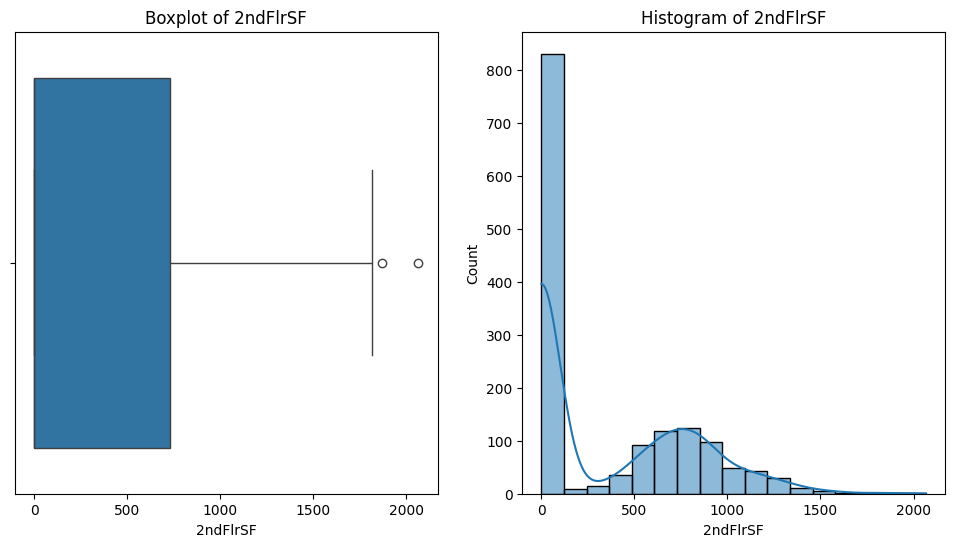

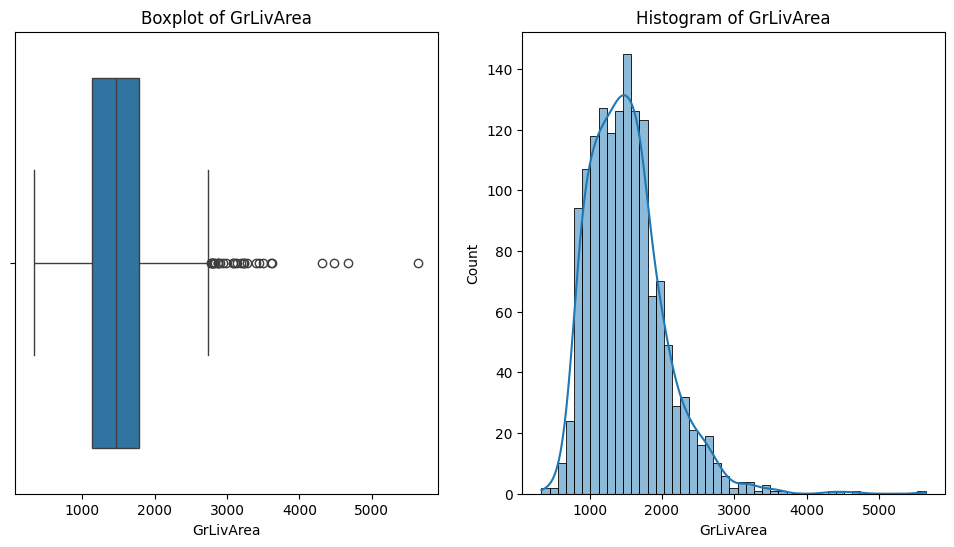

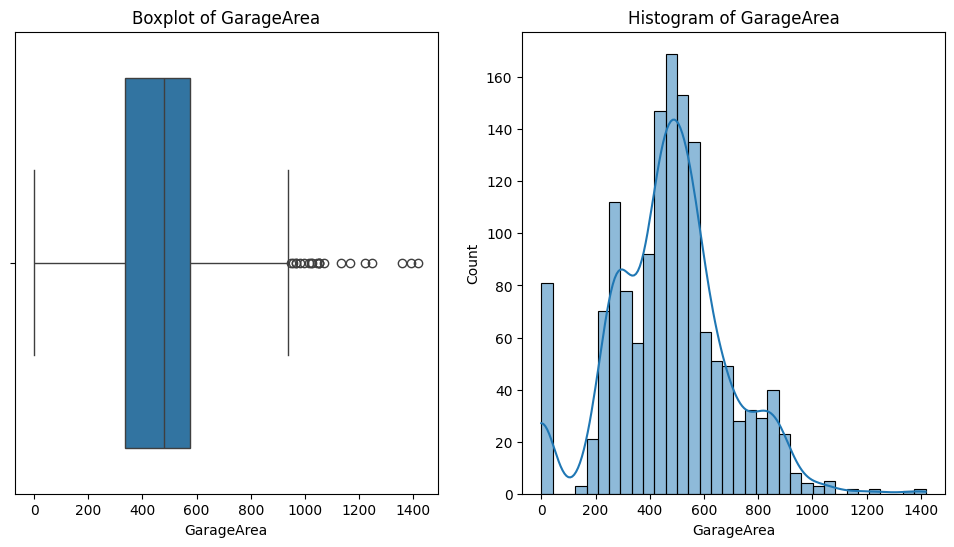

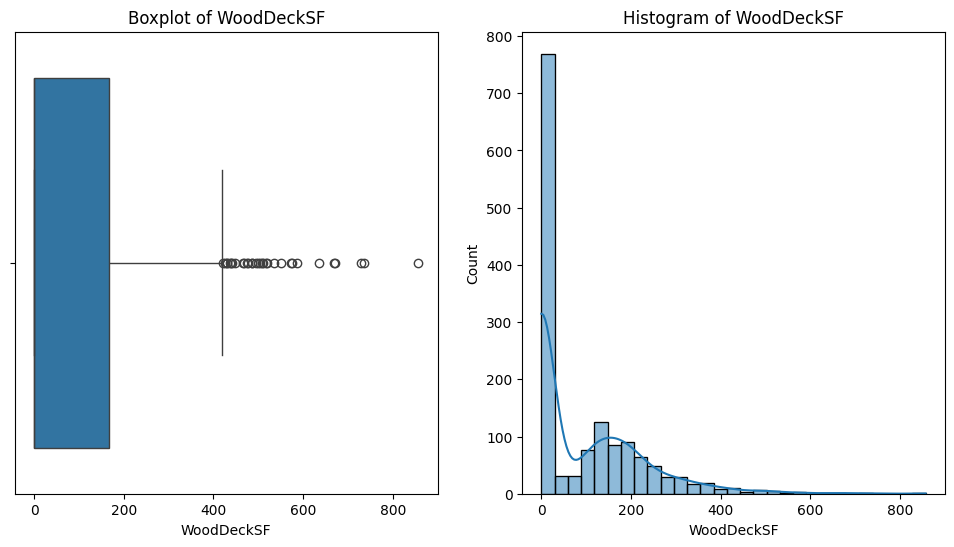

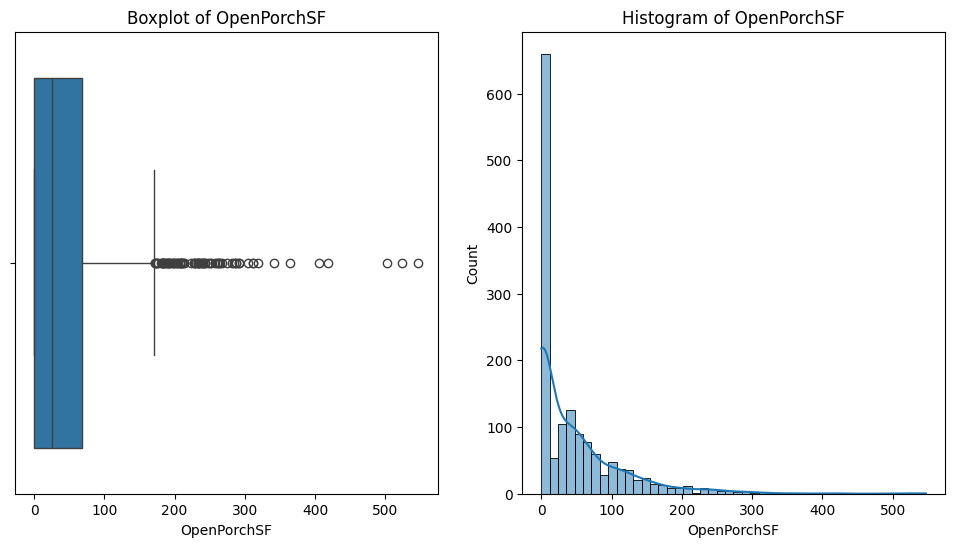

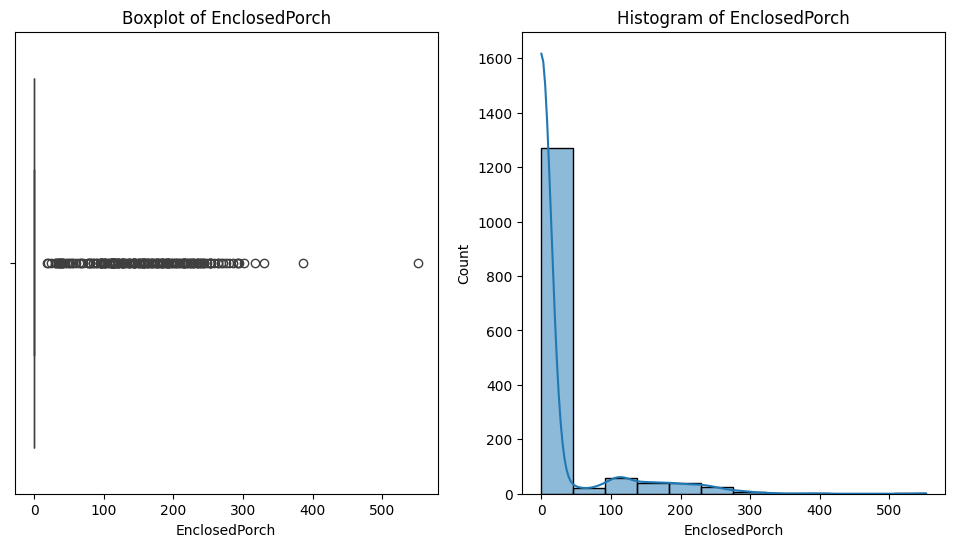

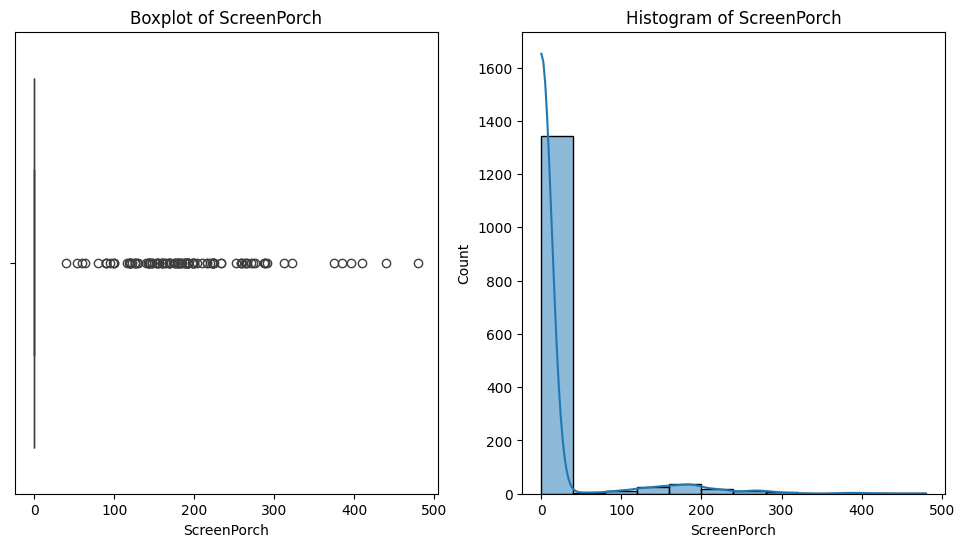

In [46]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','ScreenPorch']

for col in continuous_cols:
    plt.figure(figsize=(12, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')

    # Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(X[col], kde=True)
    plt.title(f'Histogram of {col}')

    plt.show()

In [47]:
#Since, these features have lots of outliers, RobustScaler() should be used rather than standardScalar
scaler = RobustScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num[continuous_cols]), columns=continuous_cols)
X_num_scaled = pd.concat([X_num_scaled, X_num.drop(continuous_cols, axis=1)], axis=1)

In [48]:
# #using power transformer
# pt = PowerTransformer()
# X_num_scaled[continuous_cols] = pt.fit_transform(X_num_scaled[continuous_cols])

In [51]:
order_matters_cols = [ "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "GarageType", "GarageFinish", "GarageQual", "GarageCond","PavedDrive", "SaleType", "SaleCondition"]

other_cols = ["Neighborhood","Condition1", "Condition2","MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Heating", "CentralAir", "Electrical", "Functional" ]
ordinal_encoder = OrdinalEncoder()
one_hot = OneHotEncoder(sparse_output=False)

one_hot_cols = one_hot.fit_transform(X_obj[other_cols])
X_obj_complete = pd.concat([X_obj.drop(other_cols, axis=1), pd.DataFrame(one_hot_cols, columns=one_hot.get_feature_names_out(other_cols))], axis=1)
ordinal_cols = ordinal_encoder.fit_transform(X_obj[order_matters_cols])
X_obj_complete = pd.concat([X_obj_complete.drop(order_matters_cols, axis = 1), pd.DataFrame(ordinal_cols, columns = order_matters_cols)], axis=1)

In [52]:
one_hot_cols, X_obj[order_matters_cols].shape, ordinal_cols

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (1460, 23),
 array([[0., 5., 1., ..., 2., 8., 4.],
        [0., 2., 1., ..., 2., 8., 4.],
        [0., 5., 1., ..., 2., 8., 4.],
        ...,
        [0., 5., 1., ..., 2., 8., 4.],
        [0., 2., 3., ..., 2., 8., 4.],
        [0., 2., 1., ..., 2., 8., 4.]]))

In [53]:
X_obj.shape, len(order_matters_cols) + len(other_cols), one_hot_cols.shape, X_obj_complete.columns.tolist()

((1460, 37),
 37,
 (1460, 87),
 ['Neighborhood_Blmngtn',
  'Neighborhood_Blueste',
  'Neighborhood_BrDale',
  'Neighborhood_BrkSide',
  'Neighborhood_ClearCr',
  'Neighborhood_CollgCr',
  'Neighborhood_Crawfor',
  'Neighborhood_Edwards',
  'Neighborhood_Gilbert',
  'Neighborhood_IDOTRR',
  'Neighborhood_MeadowV',
  'Neighborhood_Mitchel',
  'Neighborhood_NAmes',
  'Neighborhood_NPkVill',
  'Neighborhood_NWAmes',
  'Neighborhood_NoRidge',
  'Neighborhood_NridgHt',
  'Neighborhood_OldTown',
  'Neighborhood_SWISU',
  'Neighborhood_Sawyer',
  'Neighborhood_SawyerW',
  'Neighborhood_Somerst',
  'Neighborhood_StoneBr',
  'Neighborhood_Timber',
  'Neighborhood_Veenker',
  'Condition1_Artery',
  'Condition1_Feedr',
  'Condition1_Norm',
  'Condition1_PosA',
  'Condition1_PosN',
  'Condition1_RRAe',
  'Condition1_RRAn',
  'Condition1_RRNe',
  'Condition1_RRNn',
  'Condition2_Artery',
  'Condition2_Feedr',
  'Condition2_Norm',
  'Condition2_PosA',
  'Condition2_PosN',
  'Condition2_RRAe',
  'Cond

In [54]:
X_complete = pd.concat([X_num_scaled, X_obj_complete], axis=1)

In [55]:
# X_complete.drop(features_to_drop, axis=1, inplace=True)

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X_complete, y, test_size=0.2, random_state=42)

#Using Voting Ensemble on LGBM, XGBoost and Random Forest


<h2 style="font-family: 'Arial', sans-serif; text-align: left; padding-bottom: 3px; font-size: 18px;">Best hyperparameters found using GridSearch for best performing models </h2>



## Cant't upload the result right now, beacuse it hasn't trained yet, Will do As soon as it is done 😔😔😔


In [ ]:


param_grid_rf = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}
rf_model = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
rf_best_params = grid_search_rf.best_params_
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for Random Forest:  {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 42}


In [ ]:

rf_model=RandomForestRegressor(**rf_best_params)

In [57]:
#Haven't made these models yet because the computational power required is too high

voting_regressor = VotingRegressor(estimators=[('xgb', xgb_model), ('lgbm', lgbm_model), ('rf', rf_model)], verbose=0)
voting_regressor.fit(X_train, y_train)

NameError: name 'xgb_model' is not defined

In [ ]:
print("Model Weights:", voting_regressor.weights_)

In [ ]:
voting_preds = voting_regressor.predict(X_valid)
mse_voting = mean_squared_log_error(voting_preds,y_valid)
rmsle_voting = np.sqrt(mse_voting)
print(rmsle_voting)

In [ ]:
base_models = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm',lgbm_model)]

<div style="text-align: center;">
  <h2 style="font-family: 'Arial', sans-serif; padding-bottom: 3px; font-size: 24px; color: #FF073A; display: inline-block; background-color: #FFD999;">DATA PREPROCESSING(TEST)</h2>
</div>


In [58]:
idx = test['Id']# will use later in submission

In [59]:
test.drop('Id',axis=1,inplace=True)
test.drop(features_to_drop,axis=1,inplace=True)

In [60]:
pd.set_option('display.max_rows',80)
test.isnull().sum().to_frame()

0
MSSubClass       0
MSZoning         4
LotFrontage    227
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        2
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrArea      15
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual        44
BsmtCond        45
BsmtExposure    44
BsmtFinType1    42
BsmtFinSF1       1
BsmtFinType2    42
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     2
BsmtHalfBath     2
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      1
TotRmsAbvGrd     0
Functional       2
Fireplaces       0
GarageType      76
GarageYrBlt     78
GarageFinish    78
GarageCars       1
GarageArea       1
GarageQual      78
GarageCond      78
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0

In [61]:
test_num = test.select_dtypes(include=["int64","float64"])
test_obj = test.drop(columns=X_num)

In [62]:
test_obj.isnull().sum().to_frame()

0
MSZoning        4
Street          0
LotShape        0
LandContour     0
Utilities       2
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
RoofStyle       0
RoofMatl        0
Exterior1st     1
Exterior2nd     1
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual       44
BsmtCond       45
BsmtExposure   44
BsmtFinType1   42
BsmtFinType2   42
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
KitchenQual     1
Functional      2
GarageType     76
GarageFinish   78
GarageQual     78
GarageCond     78
PavedDrive      0
SaleType        1
SaleCondition   0

In [64]:
Lot_avg=test.groupby("Neighborhood")["LotFrontage"].mean()
test_num["LotFrontage"]=test["LotFrontage"].fillna(X["Neighborhood"].map(Lot_avg))

test["GarageYrBlt"] = test["GarageYrBlt"].fillna(0)
test_num["GarageYrBlt"] = test["GarageYrBlt"]

MasVnrArea_avg=test.groupby("Neighborhood")["MasVnrArea"].mean()
test["MasVnrArea"]=test["MasVnrArea"].fillna(test["Neighborhood"].map(MasVnrArea_avg))
test_num["MasVnrArea"] = test["MasVnrArea"]

test_num = test_num.fillna(test_num.mean())

In [63]:
test_num.mean()

MSSubClass         57.378341
LotFrontage        68.580357
LotArea          9819.161069
OverallQual         6.078821
OverallCond         5.553804
YearBuilt        1971.357779
YearRemodAdd     1983.662783
MasVnrArea        100.709141
BsmtFinSF1        439.203704
BsmtFinSF2         52.619342
BsmtUnfSF         554.294925
TotalBsmtSF      1046.117970
1stFlrSF         1156.534613
2ndFlrSF          325.967786
LowQualFinSF        3.543523
GrLivArea        1486.045922
BsmtFullBath        0.434454
BsmtHalfBath        0.065202
FullBath            1.570939
HalfBath            0.377656
BedroomAbvGr        2.854010
KitchenAbvGr        1.042495
TotRmsAbvGrd        6.385195
Fireplaces          0.581220
GarageYrBlt      1977.721217
GarageCars          1.766118
GarageArea        472.768861
WoodDeckSF         93.174777
OpenPorchSF        48.313914
EnclosedPorch      24.243317
3SsnPorch           1.794380
ScreenPorch        17.064428
PoolArea            1.744345
MiscVal            58.167923
MoSold              6.104181
YrSold           2007.769705
dtype: float64

In [65]:
test["BsmtQual"].isnull().sum()

44

In [67]:
test.loc[test["OverallQual"]>=8,"BsmtCond"]=test.loc[test["OverallQual"]>=8,"BsmtQual"].fillna("Ex")
test.loc[test["OverallQual"]>=6,"BsmtCond"]=test.loc[test["OverallQual"]>=6,"BsmtQual"].fillna("Gd")
test.loc[test["OverallQual"]>=5,"BsmtCond"]=test.loc[test["OverallQual"]>=5,"BsmtQual"].fillna("TA")
test.loc[test["OverallQual"]>=4,"BsmtCond"]=test.loc[test["OverallQual"]>=4,"BsmtQual"].fillna("Fa")
test.loc[test["OverallQual"]<4,"BsmtCond"]=test.loc[test["OverallQual"]<4,"BsmtQual"].fillna("Po")
test_obj["BsmtCond"] = test['BsmtCond']

test.loc[test["OverallQual"]>=8,"BsmtQual"]=test.loc[test["OverallQual"]>=8,"BsmtQual"].fillna("Ex")
test.loc[(test["OverallQual"] >= 6) & (test["OverallQual"] < 8), "BsmtQual"] = test.loc[(test["OverallQual"] >= 6) & (test["OverallQual"] < 8), "BsmtQual"].fillna("Gd")
test.loc[(test["OverallQual"] >= 4) & (test["OverallQual"] < 6), "BsmtQual"] = test.loc[(test["OverallQual"] >= 4) & (test["OverallQual"] < 6), "BsmtQual"].fillna("Fa")
test.loc[test["OverallQual"]<4,"BsmtQual"]=test.loc[test["OverallQual"]<4,"BsmtQual"].fillna("Fa")
test_obj["BsmtQual"] =  test["BsmtQual"]

test["BsmtExposure"]=test["BsmtExposure"].fillna("No")
test_obj['BsmtExposure'] = test['BsmtExposure']

c=test.groupby("OverallCond")["BsmtFinType1"].transform(lambda x: x.mode().iloc[0])
test["BsmtFinType1"]=test["BsmtFinType1"].fillna(MasVnrArea_avg)
test_obj["BsmtFinType1"] = test["BsmtFinType1"]
fintype2_mode=test.groupby("OverallCond")["BsmtFinType2"].transform(lambda x:x.mode().iloc[0])
test["BsmtFinType2"]=test["BsmtFinType2"].fillna(fintype2_mode)
test_obj["BsmtFinType2"] = test["BsmtFinType2"]

test["Electrical"]=test["Electrical"].fillna("SBrkr")
test_obj["Electrical"] = test["Electrical"]

test["GarageType"]= test["GarageType"].fillna("NG")
test_obj["GarageType"] = test["GarageType"]
test["GarageFinish"]= test["GarageFinish"].fillna("NG")
test_obj["GarageFinish"] = test["GarageFinish"]
test["GarageQual"]= test["GarageQual"].fillna("NG")
test_obj["GarageQual"] = test["GarageQual"]
test["GarageCond"]= test["GarageCond"].fillna("NG")
test_obj["GarageCond"] = test["GarageCond"]

In [68]:
test_num.dtypes

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
dtype: object

In [69]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','ScreenPorch']
test_num_scaled = pd.DataFrame(scaler.transform(test_num[continuous_cols]), columns=continuous_cols)# scaler is the robust scaler used beforhand in training data
test_num_scaled = pd.concat([test_num_scaled, test_num.drop(continuous_cols, axis=1)], axis=1)

In [70]:
imputer = SimpleImputer(strategy="most_frequent")
column_names = test_obj.columns.tolist()
imputer.fit(test_obj[column_names])
test_obj_imputed = imputer.transform(test_obj[column_names])
test_obj_imputed = pd.DataFrame(test_obj_imputed, columns=column_names)

In [ ]:
# order_matters_cols = ["Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "SaleType", "SaleCondition"]
# other_cols = ["MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Heating", "CentralAir", "Electrical", "Functional", "PavedDrive"]
# label_encoder = LabelEncoder()
# one_hot = OneHotEncoder(sparse=False)
# for col in order_matters_cols:
#     test_obj_imputed[col] = label_encoder.fit_transform(test_obj_imputed[col])
# one_hot_cols = one_hot.fit_transform(test_obj_imputed[other_cols])
# test_obj_complete = pd.concat([test_obj_imputed.drop(other_cols, axis=1), pd.DataFrame(one_hot_cols, columns=one_hot.get_feature_names_out(other_cols))], axis=1)

In [72]:
order_matters_cols = [ "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "GarageType", "GarageFinish", "GarageQual", "GarageCond","PavedDrive", "SaleType", "SaleCondition"]
other_cols = ["Neighborhood","Condition1", "Condition2","MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Heating", "CentralAir", "Electrical", "Functional" ]
ordinal_encoder = OrdinalEncoder()
one_hot = OneHotEncoder(sparse_output=False)

one_hot_cols = one_hot.fit_transform(test_obj_imputed[other_cols])
test_obj_complete = pd.concat([test_obj_imputed.drop(other_cols, axis=1), pd.DataFrame(one_hot_cols, columns=one_hot.get_feature_names_out(other_cols))], axis=1)
ordinal_cols = ordinal_encoder.fit_transform(test_obj_imputed[order_matters_cols])
test_obj_complete = pd.concat([test_obj_complete.drop(order_matters_cols, axis = 1), pd.DataFrame(ordinal_cols, columns = order_matters_cols)], axis=1)

In [73]:
test_complete = pd.concat([test_num_scaled, test_obj_complete], axis=1)

In [74]:
missing_cols = set(X_complete) - set(test_complete)
print(list(missing_cols))

['Heating_OthW', 'Electrical_Mix', 'Heating_Floor', 'Condition2_RRAn', 'Condition2_RRNn', 'Condition2_RRAe', 'Utilities_NoSeWa']


In [75]:
# missing_cols = ['Neighborhood_Edwards', 'Neighborhood_BrkSide', 'Neighborhood_NAmes', 'Neighborhood_Veenker', 'Condition1_Norm', 'Neighborhood_NWAmes', 'Neighborhood_NPkVill', 'Condition1_Artery', 'Condition1_RRNn', 'Neighborhood_StoneBr', 'Neighborhood_MeadowV', 'Heating_OthW', 'Neighborhood_Blueste', 'Neighborhood_Timber', 'Condition2_Norm', 'Condition1_Feedr', 'Neighborhood_Mitchel', 'Neighborhood_CollgCr', 'Condition2_RRAn', 'Neighborhood_ClearCr', 'Neighborhood_NoRidge', 'Condition1_RRAe', 'Neighborhood_OldTown', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Condition1_RRAn', 'Neighborhood_Gilbert', 'Heating_Floor', 'Condition2_RRAe', 'Neighborhood_SawyerW', 'Electrical_Mix', 'Condition2_Artery', 'Condition1_PosN', 'Neighborhood_Somerst', 'Condition1_RRNe', 'Neighborhood_Crawfor', 'Condition2_Feedr', 'Neighborhood_Blmngtn', 'Condition2_PosN', 'Condition2_RRNn', 'Neighborhood_NridgHt', 'Neighborhood_Sawyer', 'Condition2_PosA', 'Condition1_PosA', 'Neighborhood_IDOTRR', 'Utilities_NoSeWa']
# X_complete[missing_cols].plot(kind = 'bar', figsize = (20, 20))

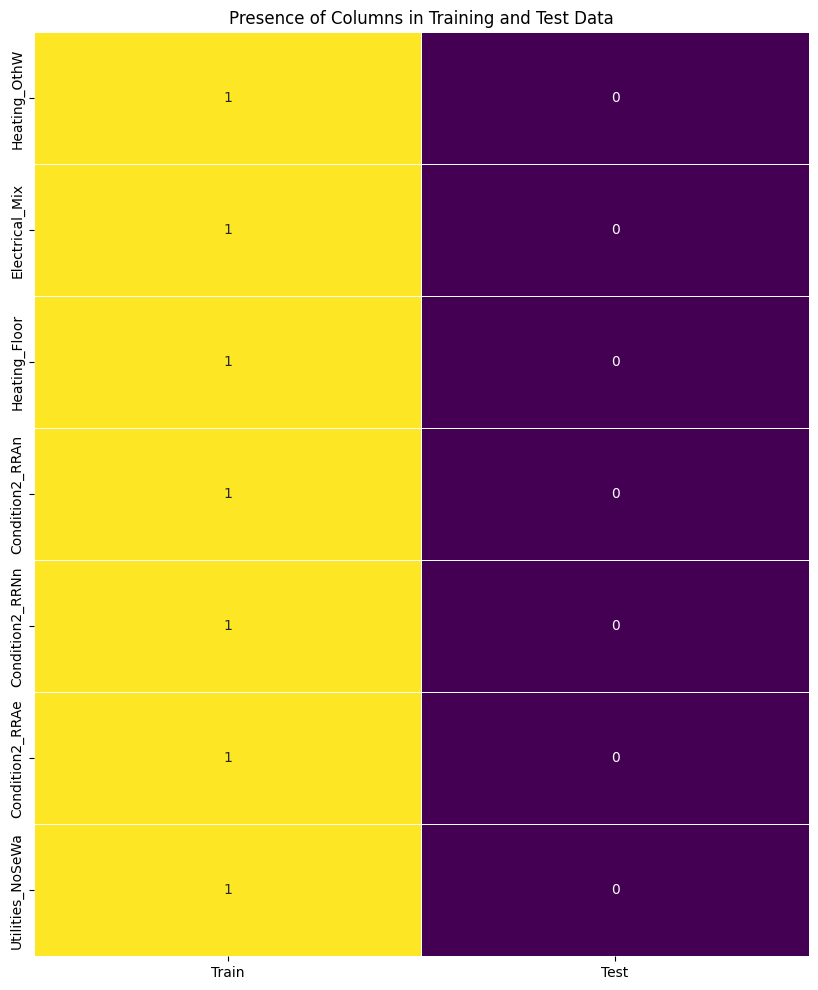

In [76]:
missing_df = pd.DataFrame({
    'Train': [1 if col in X_complete.columns else 0 for col in missing_cols],
    'Test': [1 if col in test_complete.columns else 0 for col in missing_cols]
})

# Set the index to `missing_cols`
missing_df.index = missing_cols

# Plotting the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(missing_df, annot=True, cbar=False, cmap="viridis", linewidths=.5)
plt.title('Presence of Columns in Training and Test Data')
plt.show()

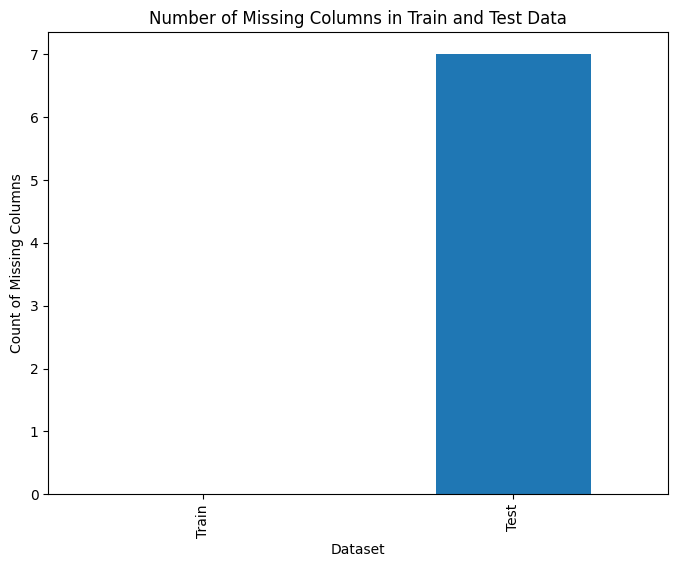

In [77]:
missing_in_train = len(set(missing_cols) - set(X_complete.columns))
missing_in_test = len(set(missing_cols) - set(test_complete.columns))

missing_counts = pd.DataFrame({'Dataset': ['Train', 'Test'], 'Missing Columns': [missing_in_train, missing_in_test]})
missing_counts.plot(kind='bar', x='Dataset', y='Missing Columns', legend=False, figsize=(8, 6))
plt.title('Number of Missing Columns in Train and Test Data')
plt.ylabel('Count of Missing Columns')
plt.show()


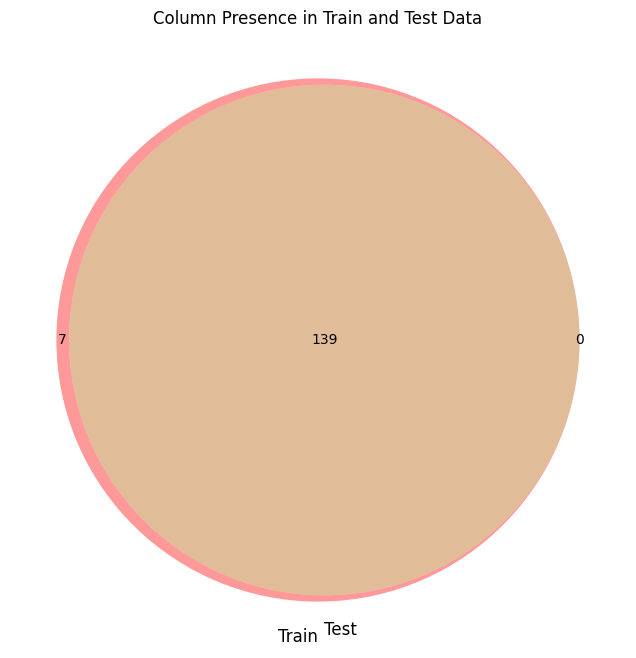

In [78]:
from matplotlib_venn import venn2

# Sets of columns
train_cols = set(X_complete.columns)
test_cols = set(test_complete.columns)

# Plotting the Venn diagram
plt.figure(figsize=(8, 8))
venn2([train_cols, test_cols], ('Train', 'Test'))
plt.title('Column Presence in Train and Test Data')
plt.show()

In [79]:

# Convert set to list
missing_cols_list = list(missing_cols)

# Create a DataFrame from the list
missing_df = pd.DataFrame({
    'Column': missing_cols_list
})


print(missing_df)


             Column
0      Heating_OthW
1    Electrical_Mix
2     Heating_Floor
3   Condition2_RRAn
4   Condition2_RRNn
5   Condition2_RRAe
6  Utilities_NoSeWa


In [80]:
# Convert set to list
missing_cols_list = list(missing_cols)

# Create a DataFrame from the list
missing_df = pd.DataFrame({
    'Column': missing_cols_list,
})

for col in missing_df['Column']:
  print(f"column is {col} and its dtype {X_complete[col].dtype} ")

column is Heating_OthW and its dtype float64 
column is Electrical_Mix and its dtype float64 
column is Heating_Floor and its dtype float64 
column is Condition2_RRAn and its dtype float64 
column is Condition2_RRNn and its dtype float64 
column is Condition2_RRAe and its dtype float64 
column is Utilities_NoSeWa and its dtype float64 


### All missing features are one hot encoded versions of categorical data, so let's just add 0

#### Now let's see the missing feature distribution in training data(this is for when i thought the missing values were numerical, so these graphs are useless, let's not delete them still)

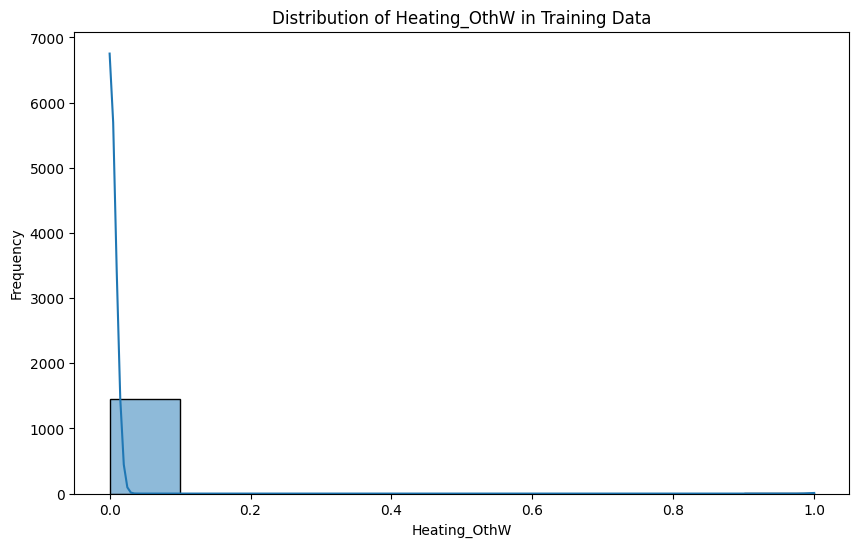

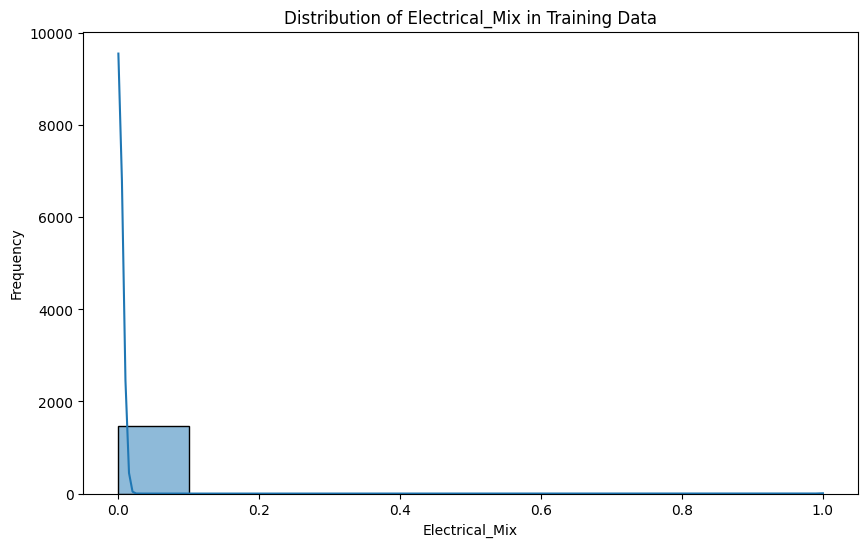

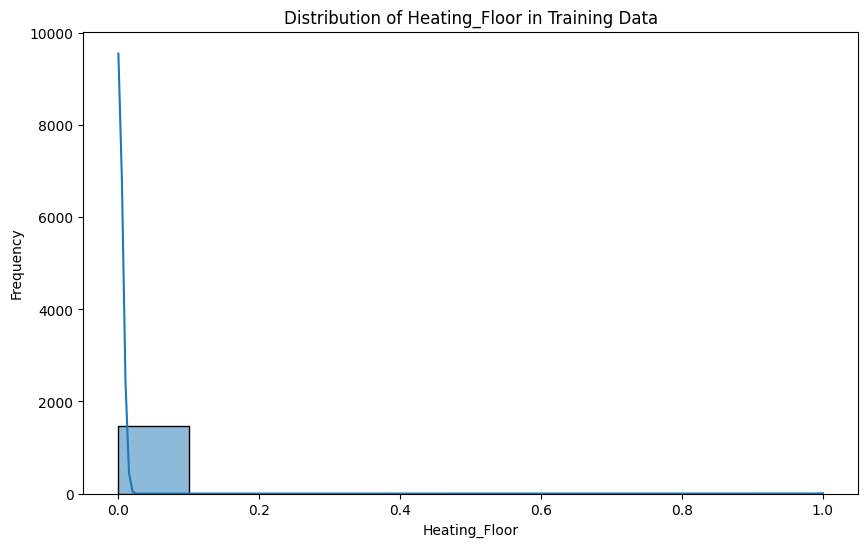

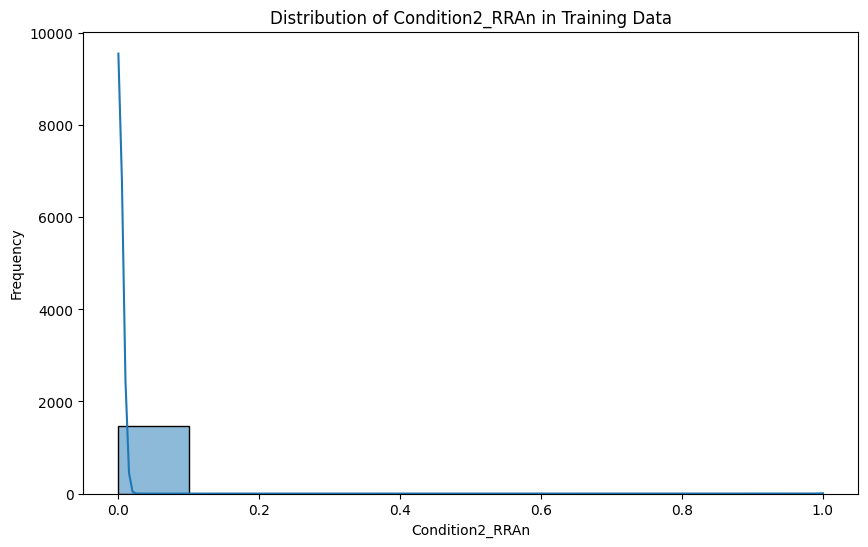

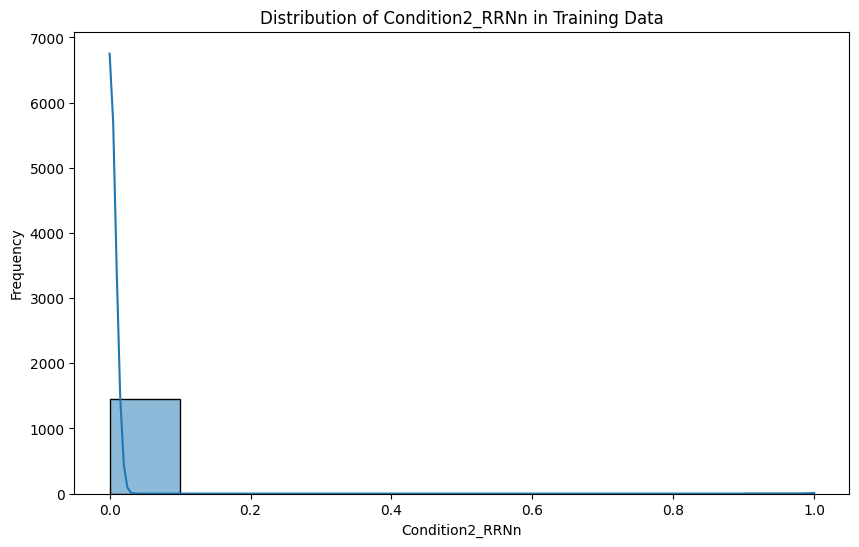

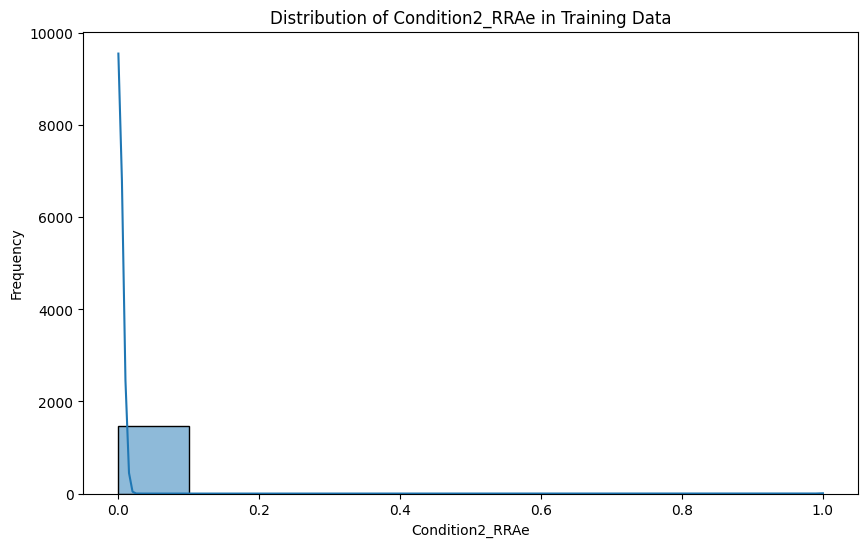

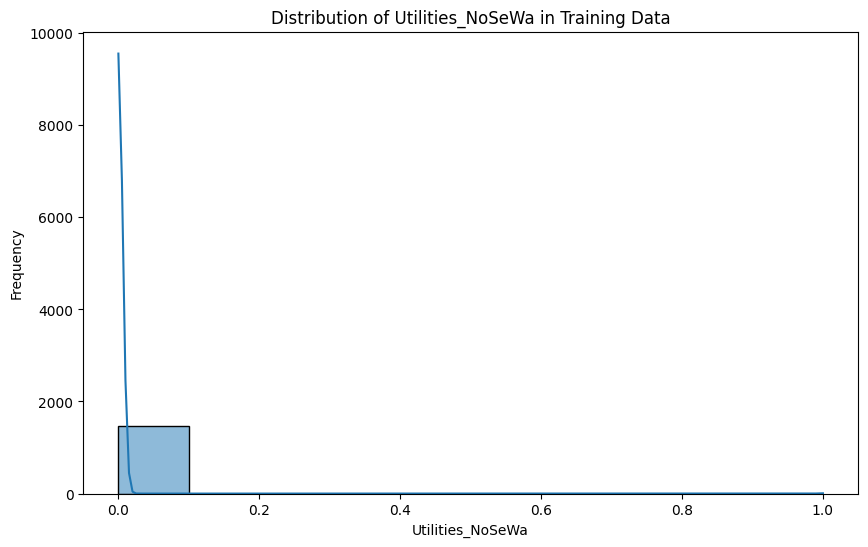

In [81]:
missing_cols_numerical = missing_df['Column'].tolist()

for col in missing_cols_numerical:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_complete[col], kde=True, bins = 10)
    plt.title(f'Distribution of {col} in Training Data')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [82]:
test_complete[list(missing_cols)] = 0.0

In [83]:
col_order = X_complete.columns

In [84]:
test_complete = test_complete.reindex(columns=col_order)

<div style="text-align: center;">
  <h2 style="font-family: 'Arial', sans-serif; padding-bottom: 3px; font-size: 24px; color: #FF073A; display: inline-block; background-color: #FFD999;">TEST PREDICTION + SUBMISSION</h2>
</div>


In [ ]:
voting_preds = voting_regressor.predict(test_complete)

NameError: name 'voting_regressor' is not defined

In [ ]:
submissions=pd.read_csv('https://raw.githubusercontent.com/Sanyam200452/House-Price-Prediction-/main/sample_submission.csv')
ids=submissions['Id']
output = pd.DataFrame({'Id': ids,
                        'SalePrice': voting_preds})

output.head()

output.to_csv('submission.csv', index=False)